In [1]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import lraspp_mobilenet_v3_large
from torchvision.models.segmentation.lraspp import LRASPPHead
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.functional import interpolate as inter
from collections import OrderedDict
#from torch.nn.functional import interpolate as inter


In [2]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
folders = [root+"/"+i for i in entries[1:]]

images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
        mat = loadmat(folder+"/"+image_data)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        

In [3]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[ 35 358 373 117 140 424 356 530 523 352 410  51 404 372 353 474 115 101
 213 271 520   5  44 351 501 513 409 360  79 438 497 367  61 119 234 514
 406 400  52  81 259 302 199 334 142 421 493 175 384 105 359 133 227 149
 321 542 492 537 157   6 148 428 459 399 109 325 415 310 454 113 260 192
  85 471 412 433 146 223 235 178 276 378 228 473 194 390 111 248 143 446
  58 298  90 376 130 202 319 470 284 161 490  20 456 541 135  17 287 169
 524 440 443 361 250  62 506 540 241 480 467 515 329 487 253  30  53 339
 252 136 348 309  37 320 182 225 239 457 463 314 531 437 218 292 251  31
 316 429 156 397 527 381  13 268 120 414 198 315 403 449 258 317 333 536
 102  56  21 330  60  92 500 427 483  97  98 507 203 233 189 264 145 256
 186   9 224 386 183 416 354 254 155 511 219 141 363  77 472 208 170 283
  84 335 231 379 393 138 465  49 304  25 380 509  86 505 206 190 365 502
 377 106 418  23 204 131 200   1  64 396 521 529 350 498 461   7 244 100
 408 132 177  42 197  46 273 419 431 402 327 121 29

In [4]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform, transform_label):
        self.input=input_data
        self.mask = mask
        self.transforms = transform
        self.transforms_label = transform_label


    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms_label(z)
            z = torch.tensor(np.asarray(z))
            z[z == 31] = 0
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=20
    epochs = 150
    HEIGHT= 256
    WIDTH = 256

In [5]:
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode as interpolate

transforms_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
transforms_label = transforms.Compose([transforms.ToPILImage(),transforms.Resize((32,32), interpolate.NEAREST)])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms_image,transforms_label)
test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

In [6]:
# class LRASPPHead_here(nn.Module):
#     def __init__(self, low_channels: int, high_channels: int, num_classes: int, inter_channels: int) -> None:
#         super().__init__()
#         self.cbr = nn.Sequential(
#             nn.Conv2d(high_channels, inter_channels, 1, bias=False),
#             nn.BatchNorm2d(inter_channels),
#             nn.ReLU(inplace=True),
#         )
#         self.scale = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(high_channels, inter_channels, 1, bias=False),
#             nn.Sigmoid(),
#         )
#         self.low_classifier = nn.Conv2d(low_channels, num_classes, 1)
#         self.high_classifier = nn.Conv2d(inter_channels, num_classes, 1)

#     def forward(self, input: Dict[str, Tensor]) -> Tensor:
#         low = input["low"]
#         high = input["high"]

#         x = self.cbr(high)
#         s = self.scale(high)
#         x = x * s
#         x = F.interpolate(x, size=low.shape[-2:], mode="bilinear", align_corners=False)

#         return self.low_classifier(low) + self.high_classifier(x)

In [7]:
# deeplabv3_resnet50
# fcn_resnet50
from torch.nn import functional as F
class MyLRASPP(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyLRASPP, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        #if pretrained:
        net = lraspp_mobilenet_v3_large(pretrained=pretrained,                             
                            pretrained_backbone= True)#num_classes=31)
                
        
        self.backbone   = net.backbone

        #self.classifier = LRASPPHead(256, 256, 31, 25)

        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        high_channels=960
        low_channels=40
        inter_channels=25
        self.cbr = nn.Sequential(
            nn.Conv2d(high_channels, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
        )
        self.scale = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(high_channels, inter_channels, 1, bias=False),
            nn.Sigmoid(),
        )
        self.low_classifier = nn.Conv2d(low_channels, num_classes, 1)
        self.high_classifier = nn.Conv2d(inter_channels, num_classes, 1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, input):
        #print(x)
        
        input = self.backbone(input)
#         x = x['out'] # the other key in the ordered dictionary is 'aux'
       
#         x = self.classifier(x)
            
        
        low = input["low"]
        high = input["high"]
#         print("low size :",low.size())
#         print("high size :",high.size())
        x = self.cbr(high)
        #print("after cbr",x.size())
        s = self.scale(high)
        x = x * s
        #print("after x*s(scale)",x.size())
        x = inter(x, size=low.shape[-2:], mode="bilinear", align_corners=False)
#         print("after interpolation",x.size())
#         print("low size :",low.size())
#         print("x size :",x.size())
        out=self.low_classifier(low) + self.high_classifier(x)
        #print("out size",out.size())
        
        
# #         out = self.classifier(features)
        #out = F.interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        #out = interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        out = inter(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
#         #out = self.classifier(features)
        result = OrderedDict()
        result["out"] = out
        return out

#         score = self.bn1(out)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
#         score = self.relu(self.deconv2(score))            # size=(2, 256, x.H/4, x.W/4)
#         score = self.bn2(score) 
#         score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
#         score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
#         score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
#         score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1) */
#         return score            


In [8]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
# model = model.train(True)
# model

model = MyLRASPP(num_classes = 31)


In [9]:
lossfunc = nn.CrossEntropyLoss(ignore_index=255)
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.1, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.0001)

In [10]:
classes = ["crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish","other"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [11]:
torch.cuda.is_available()


False

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
# training_total_loss=[]
# training_loss=[]
# testing_total_loss=[]
# testing_loss=[]
# testing_avg_loss=[]
# training_avg_loss=[]
# import torchvision.transforms.functional as F
# for epochs in range(hyperparam.epochs):
#     training_total_loss_curr_epoc=0
#     testing_total_loss_curr_epoc=0
# #     training_loss=[]
#     model.train(True)
# #     print("here")
#     with torch.set_grad_enabled(True):
# #         print("here1")
#         print(len(train_gen))
#         for batch,labels in train_gen:
            
# #             print("here2")
#             batch=batch.float()
#             labels=labels.float()
# #             print("batch size", batch.size())
# #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
# #             print(batch,label)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#             labels = torch.nn.functional.softmax(labels,dim =1)
#             predictions=model(batch)
# #             print("predictions" ,predictions)
# #             print("predictions size",predictions.size())
# #             print("norm_pred",norm_pred.size())
# #             np = torch.argmax(predictions.squeeze(),dim=1)
#             print("Predictions type")
#             print(type(predictions))
#             predictions = predictions.type(torch.FloatTensor)
# #             npred = torch.nn.functional.softmax(predictions,dim =1)
# #             print("np ", np.size())
#             labels = labels.squeeze(1)
#             labels = labels.type(torch.LongTensor)
# #             print("label size", labels.size())
#             pred_loss = lossfunc(predictions,labels) 
# #             pred_loss.requires_grad = True
# #             print(pred_loss.requires_grad)
#             optimizer.zero_grad()
#             pred_loss.backward()
#             optimizer.step()
# #             training_loss.append(pred_loss)
# #         print("training_loss",training_loss)
# #         print("training_total_loss",training_loss)
#         training_total_loss.append(pred_loss)
#         training_total_loss_curr_epoc+=pred_loss
#         print(pred_loss)
#         scheduler.step(pred_loss)
#     model.eval()
# #     print("here test")
#     with torch.set_grad_enabled(False):
# #         print("here1 test")
#         for batch,labels in test_gen:
#     #             print("here2")
#             batch=batch.float()
#             labels=labels.float()
#     #         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
# #             print("batch size", batch.size())
#     #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#     #             print(batch,label)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#             predictions=model(batch)
#     #             print("predictions" ,predictions)
#     #             print("predictions size",predictions.size())
#     #             print("norm_pred",norm_pred.size())
#     #         npred = torch.argmax(predictions.squeeze(),dim=1)
#             print("Predictions type")
#             print(type(predictions))
#             predictions = predictions.type(torch.FloatTensor)
#             npred = torch.nn.functional.softmax(predictions,dim =1)
# #             print("np ", npred.size())
#             labels = labels.squeeze(1)
#             labels = labels.type(torch.LongTensor)
#     #             print("label size", labels.size())
#             pred_loss = lossfunc(npred,labels) 
#             testing_loss.append(pred_loss)
#             testing_total_loss_curr_epoc+=pred_loss
    
#     #             print("pred_loss",pred_loss)
#     #         print("batch[0]",batch[0])
#             masks = [
#                 npred[img_idx,sem_class_to_idx[cls]]
#                 for img_idx in range(batch.shape[0])
#                 for cls in classes]
# #             break
#     avgTrainLoss = training_total_loss_curr_epoc / len(train_gen)
#     avgTestLoss = testing_total_loss_curr_epoc / len(test_gen)
#     testing_avg_loss.append(avgTestLoss)
#     training_avg_loss.append(avgTrainLoss)


In [14]:
# training_total_loss=[]

import torchvision.transforms.functional as F

def training(model): 
    model.to(device)
    temp_train = 0
    training_loss=0
    model.train(True)
#     print("here")
    with torch.set_grad_enabled(True):
#     print("here1")
        for batch,labels in train_gen:
    #             print("here2")
            batch=batch.float().to(device)
    #             print("batch size", batch.size())
    #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
    #             print(batch,label)
    #         batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    #             labels = torch.nn.functional.softmax(labels,dim =1)

            predictions=model(batch)
            labels=labels.to(device)
#             print("predictions.requires_grad",predictions.requires_grad)
#             numpy_predictions = predictions.detach().numpy()
#             np.argmax(numpy_predictions,axis = 1)
#             npred = torch.tensor(numpy_predictions)
#             print(npred.size())
            # npred = torch.softmax(predictions,dim=1)
            predicted_masks=torch.softmax(predictions,dim=1).type(torch.float)
#             print("npred.requires_grad",npred.requires_grad)
            # labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(predicted_masks,labels.long()) 
#             print("pred_loss",pred_loss)
            temp_train  += pred_loss * hyperparam.bs
#             print(pred_loss)
#             print("pred_loss.requires_grad",pred_loss.requires_grad)
#             print("pred_loss",pred_loss)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             print("pred_loss",pred_loss)
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

# # training_total_loss=[]

# # import torchvision.transforms.functional as F

# def training(model): 
#     temp_train = 0
#     training_loss=0
#     model.train(True)
# #     print("here")
# #     with torch.set_grad_enabled(True):
# #     print("here1")
#     for batch,labels in train_gen:
# #             print("here2")
#         batch=batch.float()
# #             print("batch size", batch.size())
# #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
# #             print(batch,label)
# #             labels = torch.nn.functional.softmax(labels,dim =1)

#         predictions=model(batch)
#         #print("labels size before squeeze",labels.size())
#         #labels = labels.squeeze(1)
# #         print("labels size",labels.size())
# #         print("prediction size",predictions.size())
#         predicted_masks=torch.softmax(predictions,dim=1).type(torch.float)
#         #print("prediction mask size",predicted_masks.size())
#         #print("prediction mask",predicted_masks)
#         #print("labels",labels.long().size())
#         pred_loss = lossfunc(predicted_masks,labels.long()) 
#         temp_train  += pred_loss * hyperparam.bs
        
#         optimizer.zero_grad()
#         pred_loss.backward()
#         optimizer.step()
        
#     training_loss = temp_train / len(train_gen.dataset)
#     print("Training avg loss = ",training_loss)
#     return training_loss

In [15]:

# def validate(model):
#     testing_avg_loss=0
#     testing_loss=0
# #     print("here")
#     with torch.set_grad_enabled(False):
#         model.eval()
# #         print("here1")
#         for batch,labels in test_gen:
#     #             print("here2")
#             batch=batch.float()
#             predictions=model(batch)
#             #labels = labels.squeeze(1)
#             #labels = labels.type(torch.LongTensor)
#             predicted_masks=torch.softmax(predictions,dim=1).type(torch.float)
#             pred_loss = lossfunc(predicted_masks,labels.long()) 
#             testing_loss += pred_loss * hyperparam.bs
            
#         testing_avg_loss = testing_loss/len(test_gen.dataset)
#         print("Test avg loss = ",testing_avg_loss)
#         return testing_avg_loss



def validate(model):
    testing_avg_loss=0
    testing_loss=0
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            # npred = torch.softmax(predictions,dim=1)
            predicted_masks=torch.softmax(predictions,dim=1).type(torch.float)
            labels = labels.to(device)
            pred_loss = lossfunc(predicted_masks,labels.long()) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


In [16]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target

In [17]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.target_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy

In [18]:
# training_all_loss = []
# validation_all_loss = []
# for epochs in range(hyperparam.epochs):
#     t_avg_loss = training(model)
#     training_all_loss.append(t_avg_loss)
    
#     d_avg_loss = validate(model)
#     validation_all_loss.append(d_avg_loss)

training_all_loss = []
validation_all_loss = []
index_here=0

for epochs in range(hyperparam.epochs):
    print("index here",index_here)
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss.cpu().detach().numpy())
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss.cpu().detach().numpy())
    index_here+=1

torch.save(model,'mymodelLRASPP.pth')
    

index here 0
Training avg loss =  tensor(3.5055, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.7452)
index here 1
Training avg loss =  tensor(3.5006, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.7367)
index here 2
Training avg loss =  tensor(3.4872, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.7021)
index here 3
Training avg loss =  tensor(3.4071, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.5145)
index here 4
Training avg loss =  tensor(3.3015, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4606)
index here 5
Training avg loss =  tensor(3.2608, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4387)
index here 6
Training avg loss =  tensor(3.2448, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4233)
index here 7
Training avg loss =  tensor(3.2252, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4152)
index here 8
Training avg loss =  tensor(3.2189, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4061)
index here 9
Training avg loss =  tensor(3.2096, grad_f

Test avg loss =  tensor(3.2450)
index here 78
Training avg loss =  tensor(2.9520, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2467)
index here 79
Training avg loss =  tensor(2.9483, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2455)
index here 80
Training avg loss =  tensor(2.9543, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2462)
index here 81
Training avg loss =  tensor(2.9565, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2507)
index here 82
Training avg loss =  tensor(2.9509, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2479)
index here 83
Training avg loss =  tensor(2.9546, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2499)
index here 84
Training avg loss =  tensor(2.9497, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2528)
index here 85
Training avg loss =  tensor(2.9456, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2482)
index here 86
Training avg loss =  tensor(2.9521, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2509)
index here 87


In [19]:
import matplotlib.pyplot as plt
training_total_loss = [ i.detach().numpy() for i in training_all_loss]
validation_total_loss = [ i.detach().numpy() for i in validation_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(training_total_loss)),training_total_loss)
plt.plot(range(len(validation_total_loss)),validation_total_loss)

plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Training loss curve')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

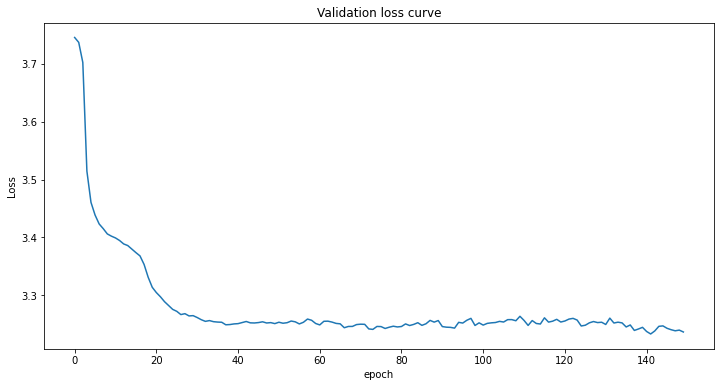

In [20]:
import matplotlib.pyplot as plt
# validation_total_loss = [ i.detach().numpy() for i in validation_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Validation loss curve')
plt.show()

In [21]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target



In [22]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.target_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy
        
        


In [ ]:
# import matplotlib
# def show_image(k):
#     cmap = matplotlib.cm.spring
#     #plt.imshow(k, cmap=cmap)
#     plt.savefig('test.png')

In [ ]:

# def validate(model):
#     testing_avg_loss=0
#     testing_loss=0
#     cal_metrics=calculate()
# #     print("here")
#     with torch.set_grad_enabled(False):
#         model.eval()
# #         print("here1")
#         count=0
#         for batch,labels in test_gen:
#     #             print("here2")
#             count+=1
#             batch=batch.float()
#             #batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#             predictions=model(batch)
#             print("prediction size",predictions.size())  
#             #print("label size before squeeze",labels.size())
#             predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
#             for mask in predicted_masks:
#                 print("pridiction", [i for i in mask])
#                 show_image(mask.numpy)
#             #print("argmax size",predicted_masks.size())
#             #print("argmax size",predictions.squeeze().size())
#             #print("labels size squeeze1",labels.size())
            
#             labels = labels.squeeze(1)
#             #print("labels size after squeeze",labels.size())
#             #print(labels[0].flatten())
#             # do it for all labels---------------
#             #labels1 = ((labels[0] - labels[0].min()) * (1/(labels[0].max() - labels[0].min())*31))
            
#             # do it for all labels---------------
#             new_labels=[]
#             for i in range(len(labels)):
#                 temp_label = ((labels[i] - labels[i].min()) * (1/(labels[i].max() - labels[i].min())*31)).type(torch.int)
#                 new_labels.append(temp_label)
            
#             new_labels=torch.stack(new_labels,dim=0)
#             cal_metrics.add(predicted_masks,new_labels) 
            
#             #print("restack new label",new_labels.size())
              
                
            
            
#             #---------------------------------------
            
#             #print(labels1.type(torch.int))
#             #print([i for i in labels[0].flatten()])
#             #print("labels size after squeeze", labels.size())
#             labels = labels.type(torch.LongTensor)
#             pred_loss = lossfunc(predictions.float(),labels) 
#             testing_loss += pred_loss * hyperparam.bs
#             #if count==2:
        
#         print("miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())
            
#         testing_avg_loss = testing_loss/len(test_gen.dataset)
#         print("Test avg loss = ",testing_avg_loss)
#         return testing_avg_loss
# d_avg_loss = validate(model)

In [ ]:

# import matplotlib.pyplot as plt
# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img2 = (img>0.5).float()
#         img = F.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# # i = 0        
# # for mask in masks:
# # #     print(i)
# #     show(mask)
# #     i=i+1
# show(masks[0:30])

In [23]:

import torchvision.transforms as T

        
def calculate_metrics(model):

    cal_metrics=calculate()
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in train_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
        print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

    cal_metrics_=calculate()
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in test_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
        print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

calculate_metrics(model)

Training set: miou,maccuracy,accuracy:  (0.21596232088664183, 0.21596232088664183, 0.7006855867346893)
Testing set: miou,maccuracy,accuracy:  (0.13843365378150974, 0.13843365378150974, 0.5291548295454253)


In [24]:
import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.to(device)
model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float().to(device)
        labels=labels.float()
#         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
#         print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#         npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1).to(device)
        print("np ", npred.size())
        labels = labels.squeeze(1).to(device)

        pred_loss = lossfunc(npred,labels.long()) 
#         testing_loss.append(pred_loss)
        print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break

here
here1
np  torch.Size([20, 31, 32, 32])
pred_loss tensor(2.9596)


<ipython-input-25-b75f03562eab>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)


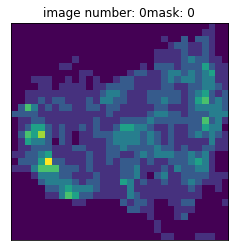

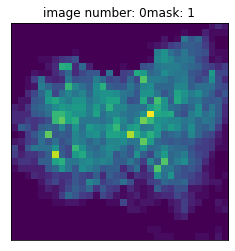

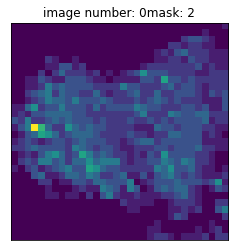

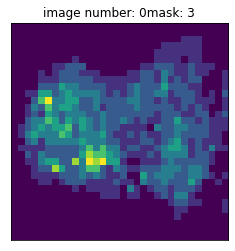

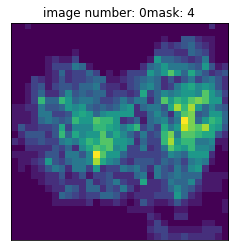

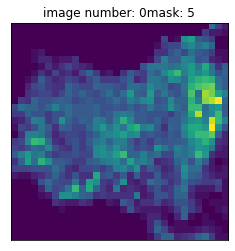

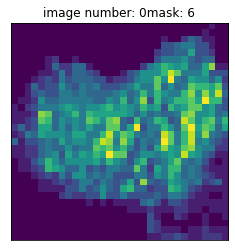

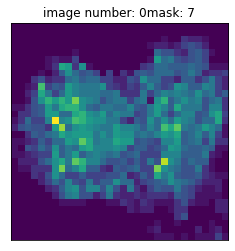

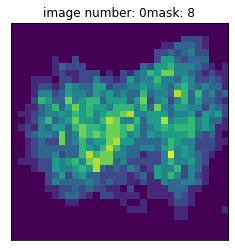

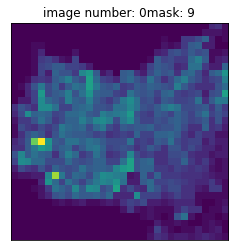

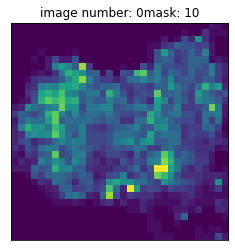

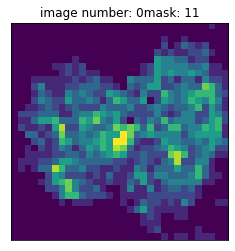

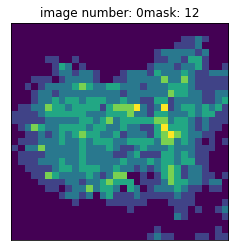

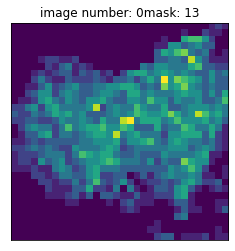

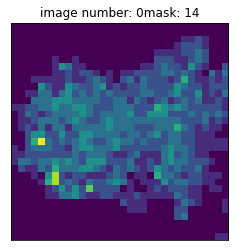

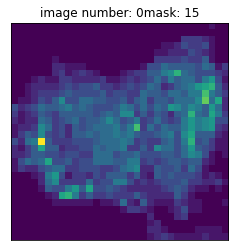

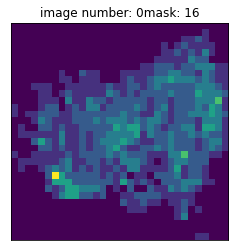

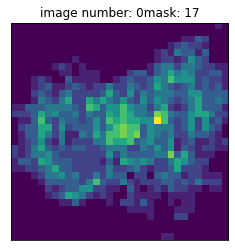

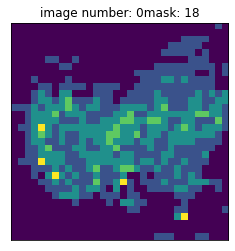

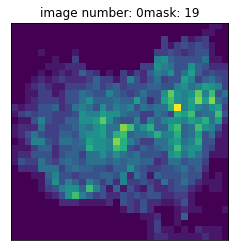

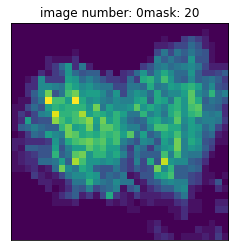

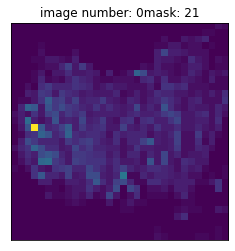

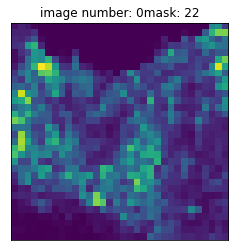

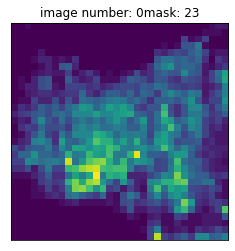

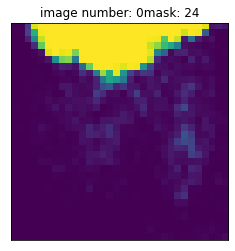

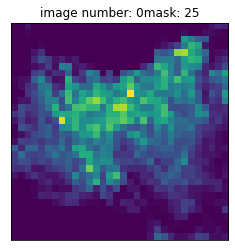

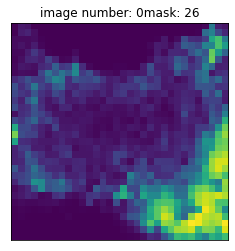

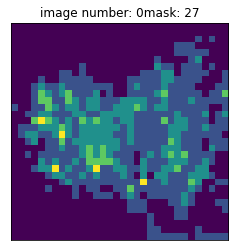

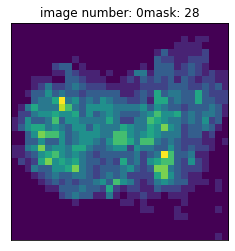

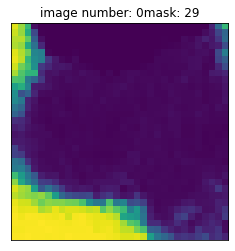

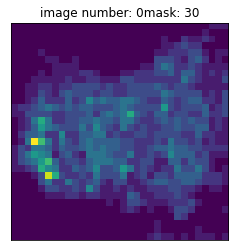

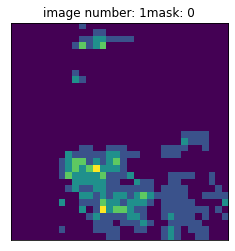

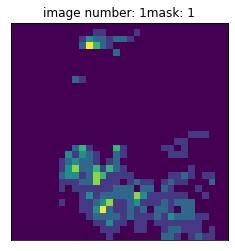

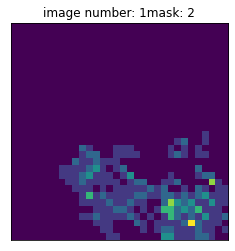

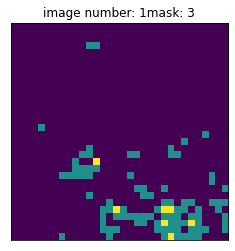

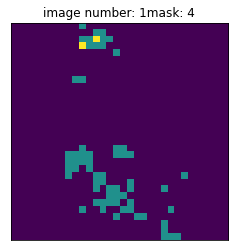

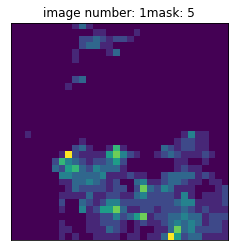

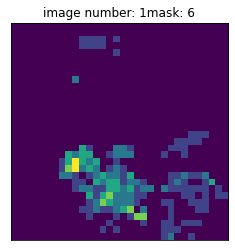

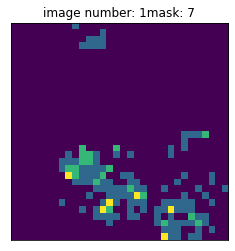

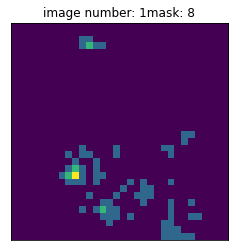

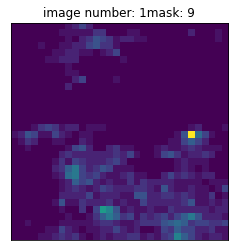

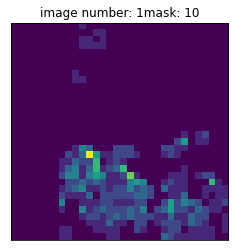

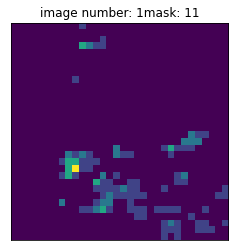

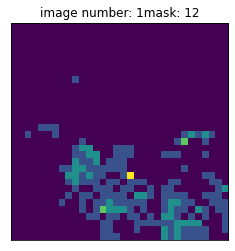

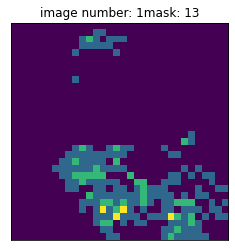

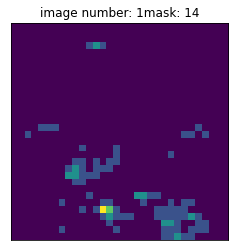

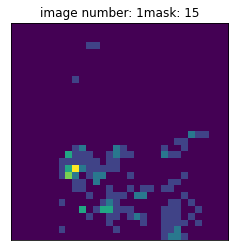

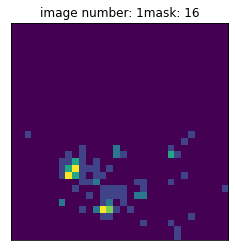

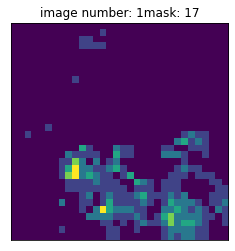

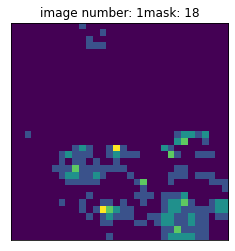

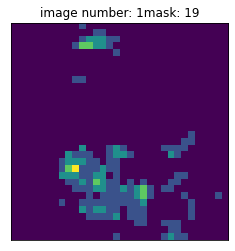

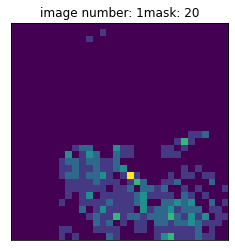

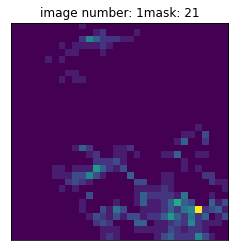

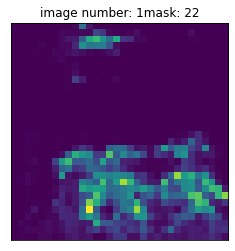

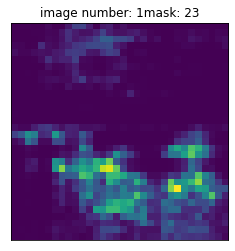

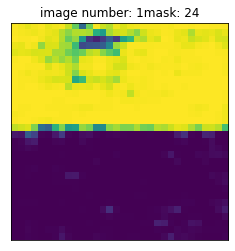

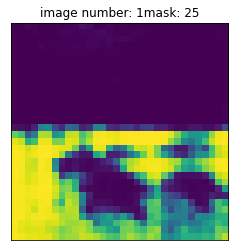

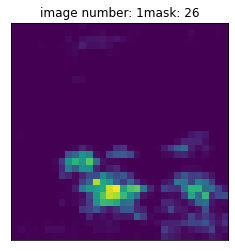

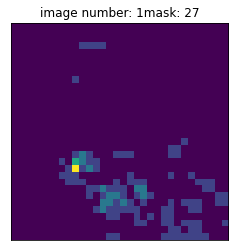

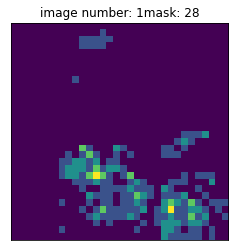

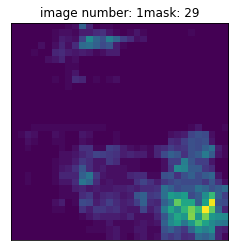

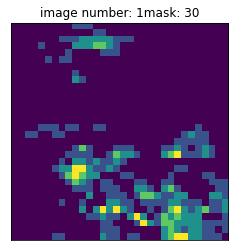

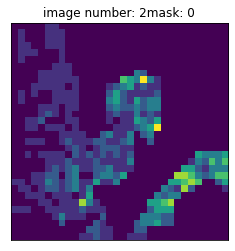

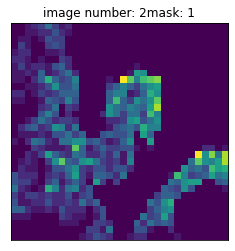

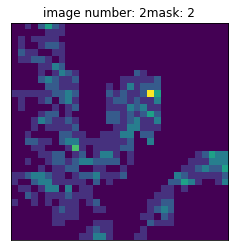

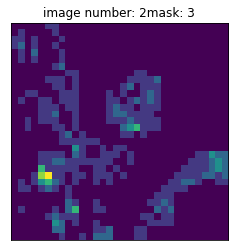

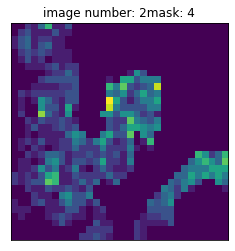

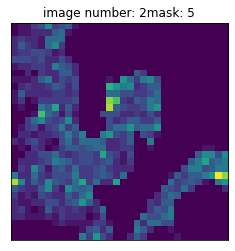

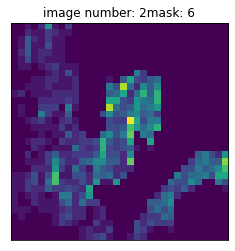

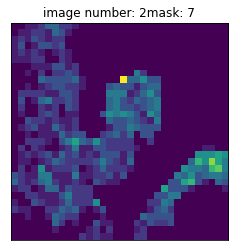

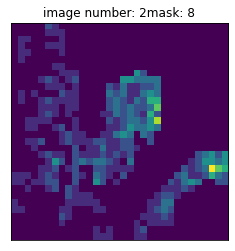

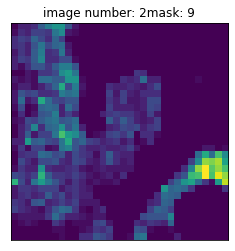

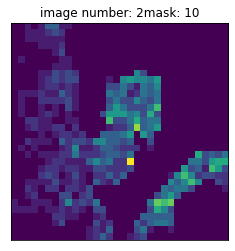

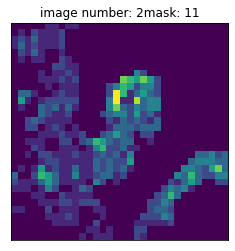

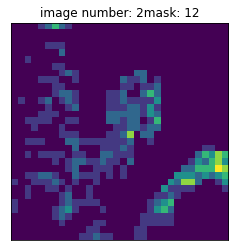

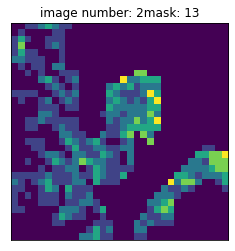

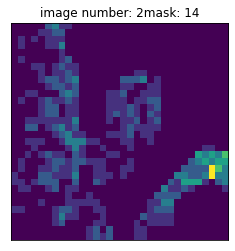

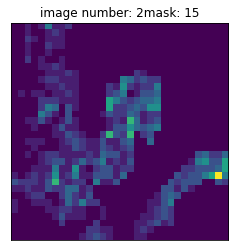

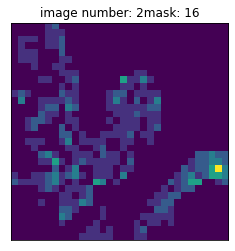

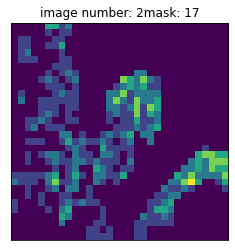

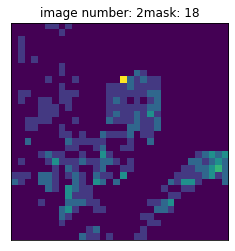

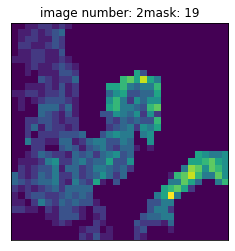

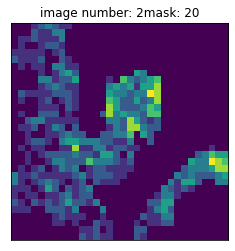

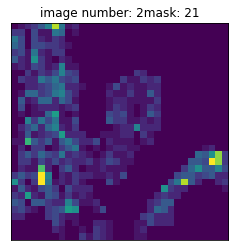

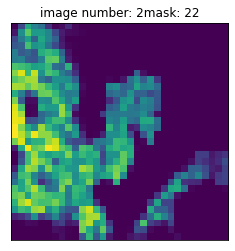

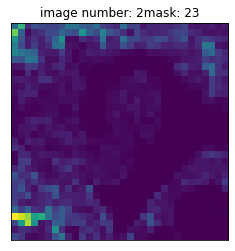

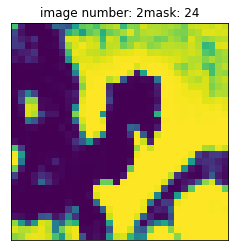

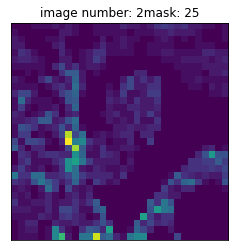

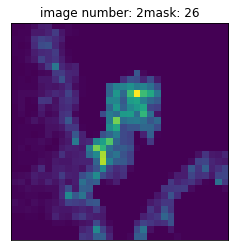

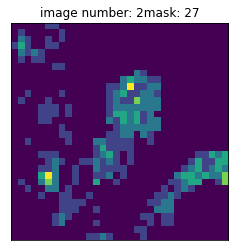

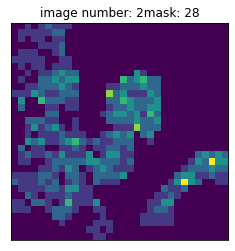

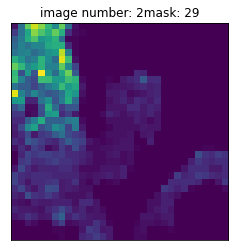

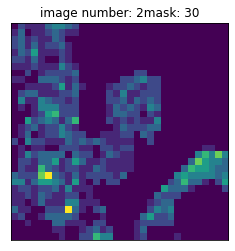

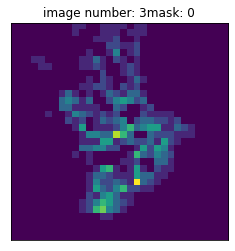

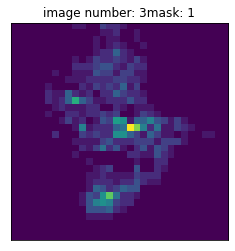

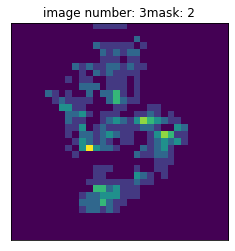

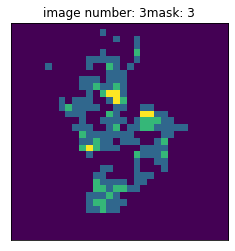

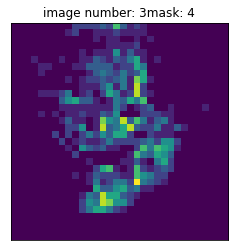

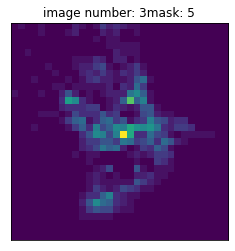

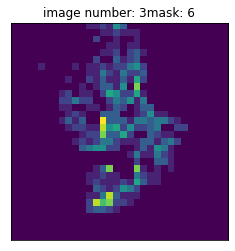

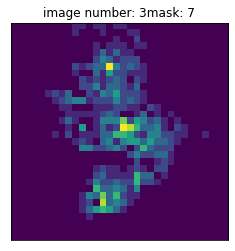

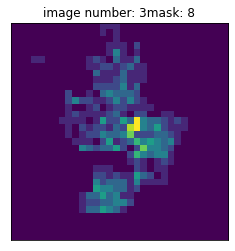

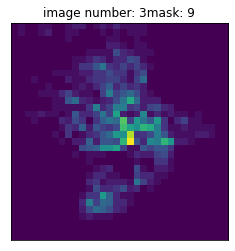

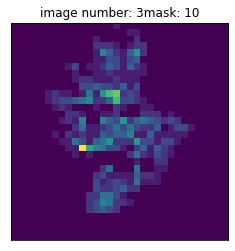

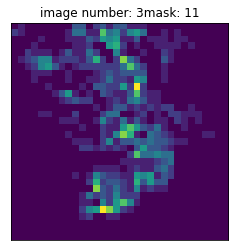

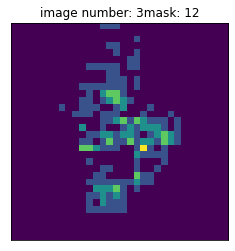

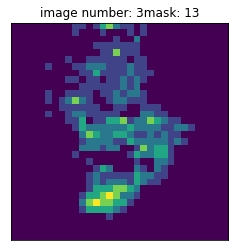

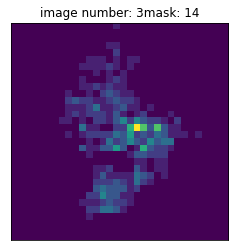

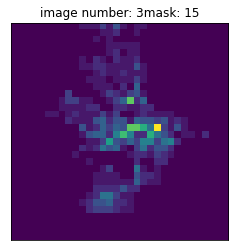

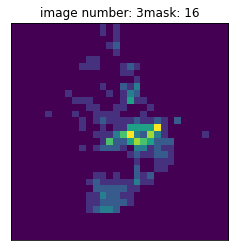

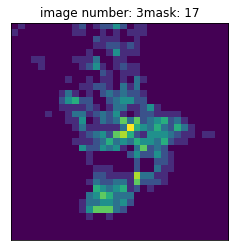

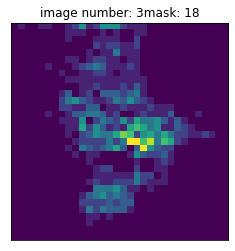

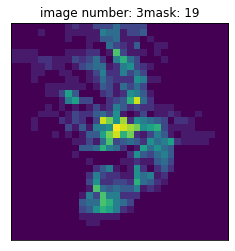

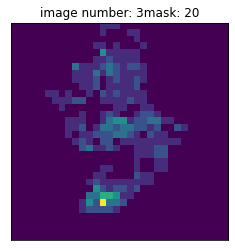

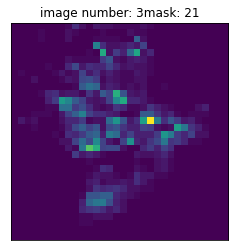

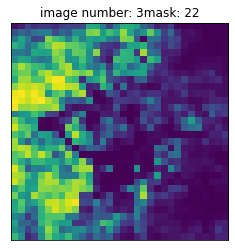

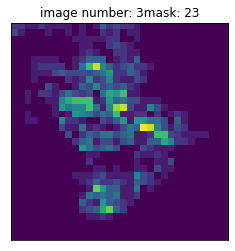

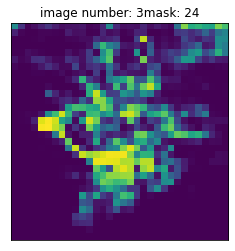

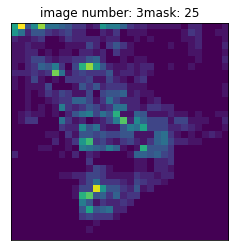

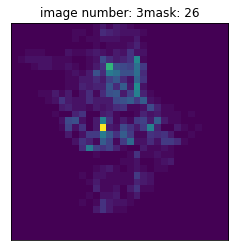

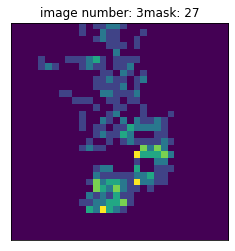

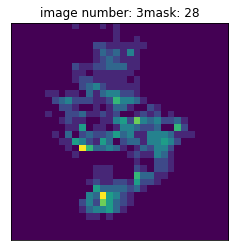

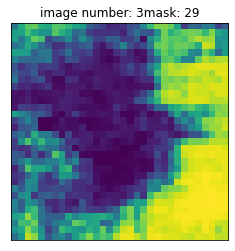

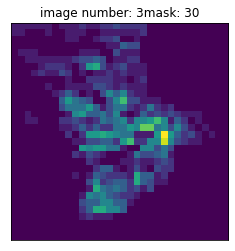

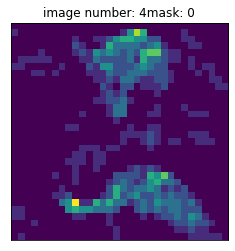

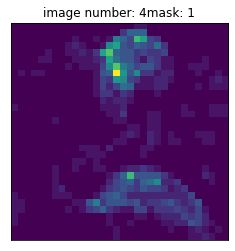

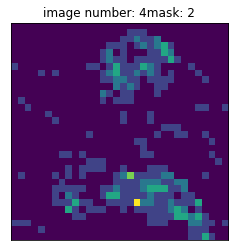

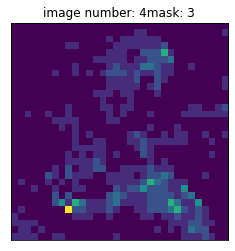

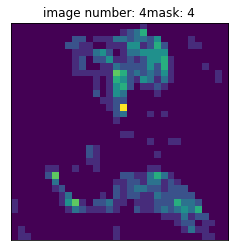

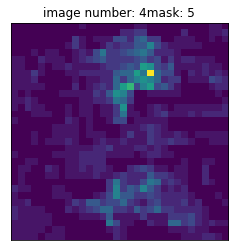

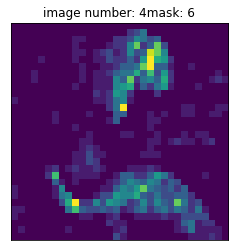

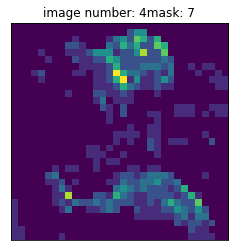

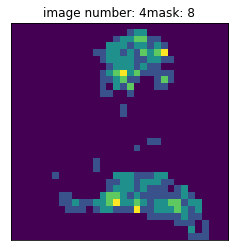

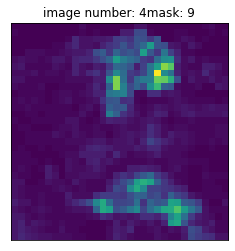

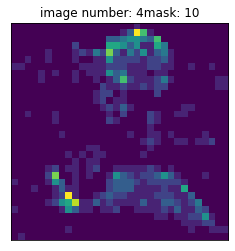

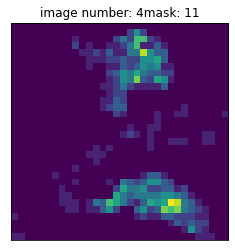

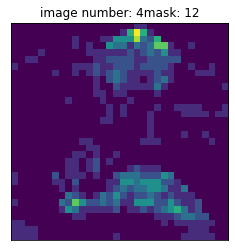

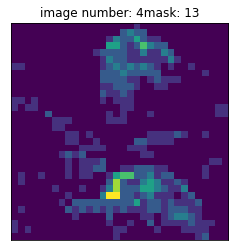

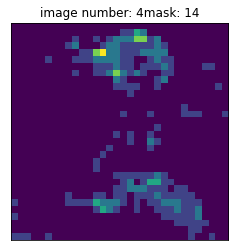

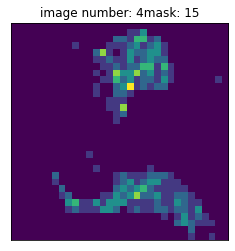

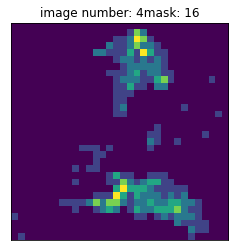

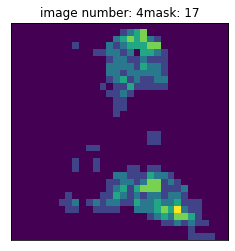

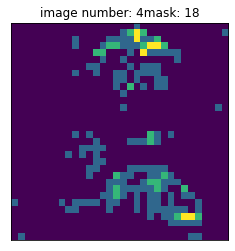

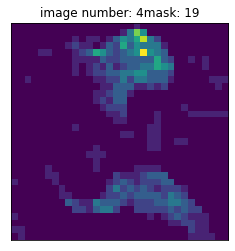

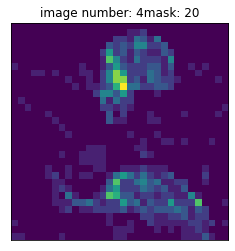

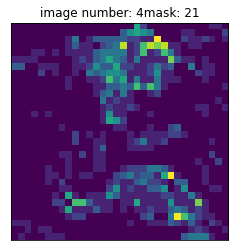

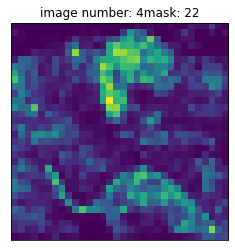

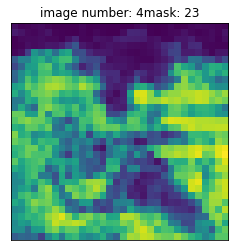

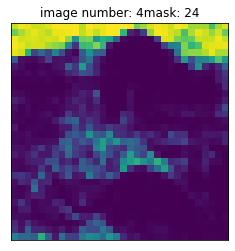

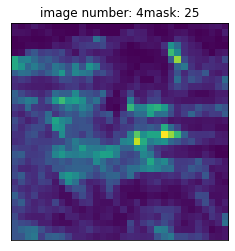

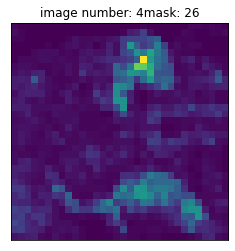

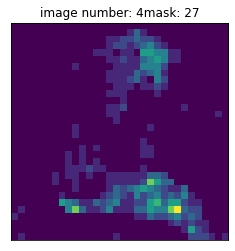

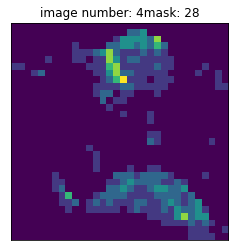

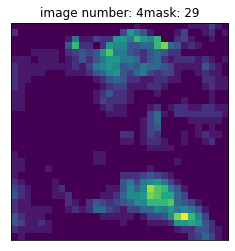

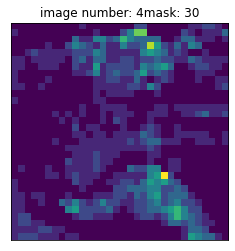

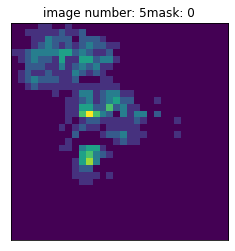

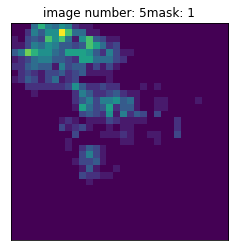

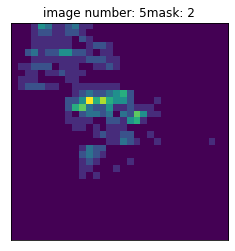

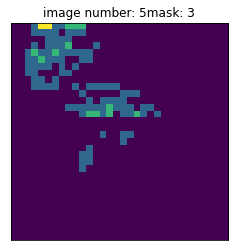

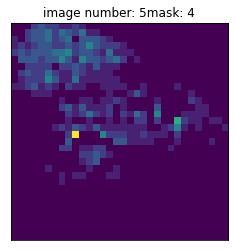

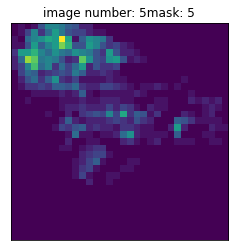

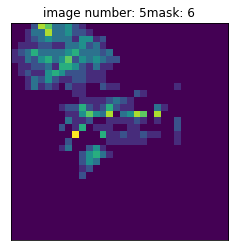

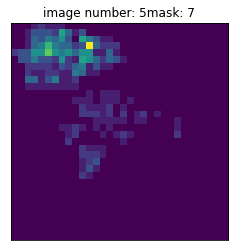

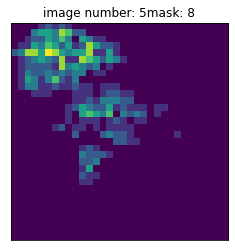

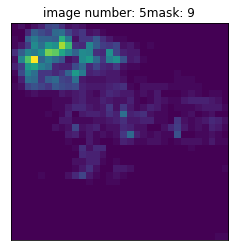

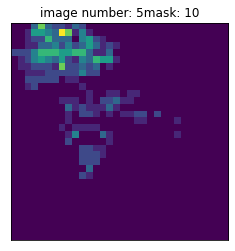

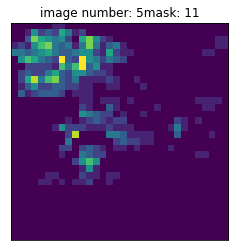

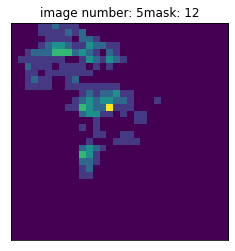

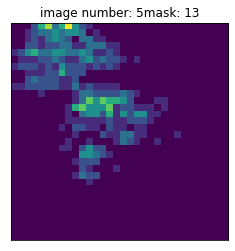

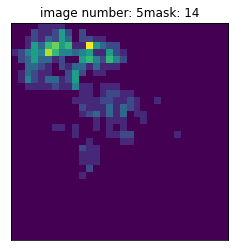

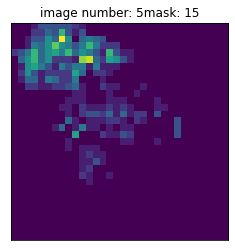

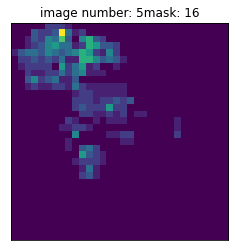

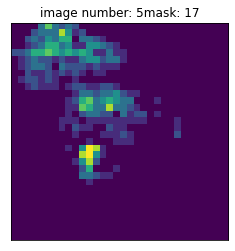

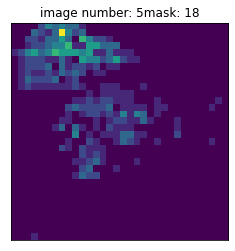

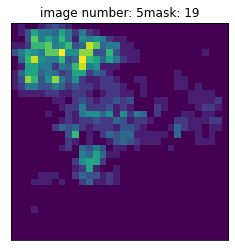

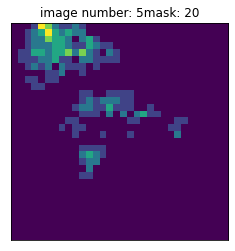

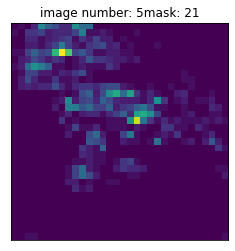

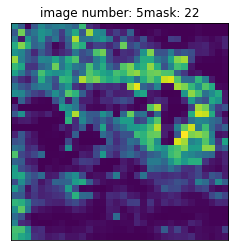

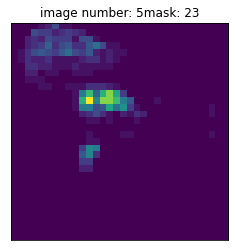

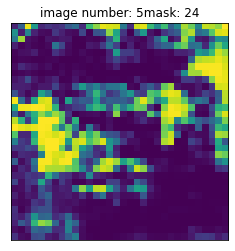

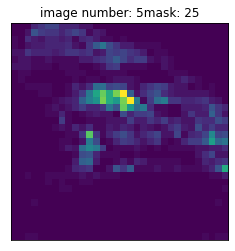

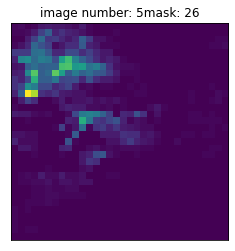

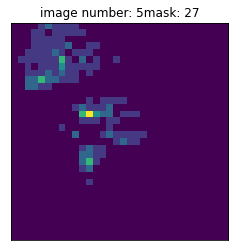

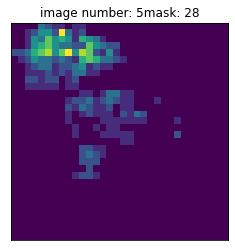

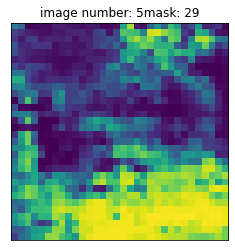

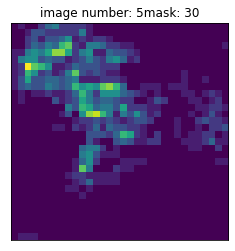

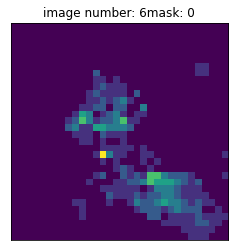

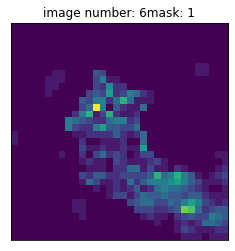

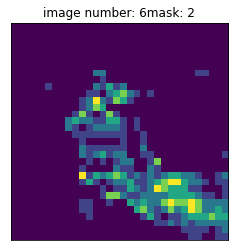

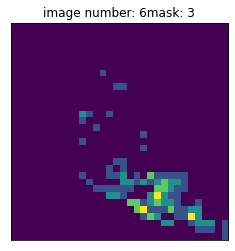

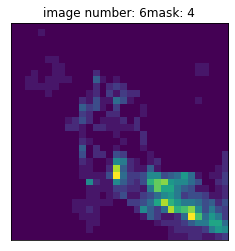

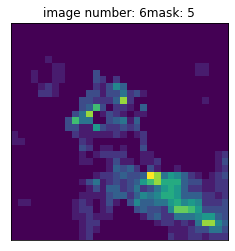

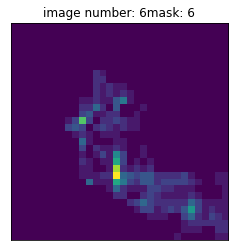

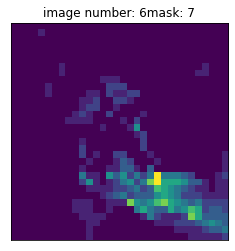

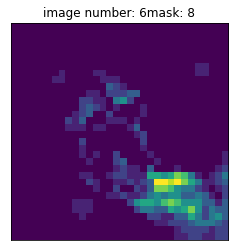

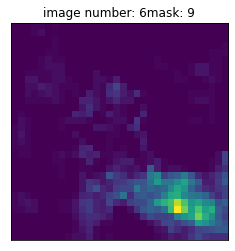

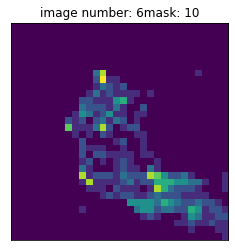

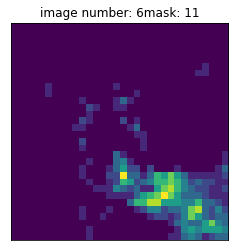

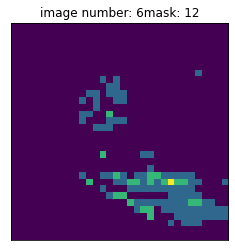

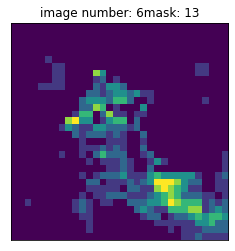

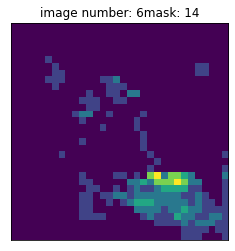

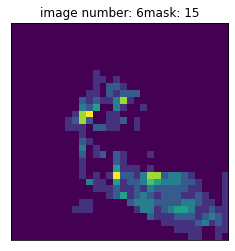

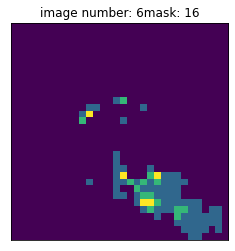

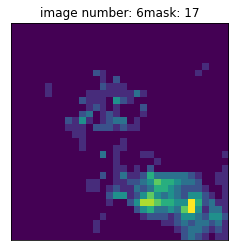

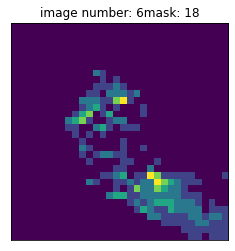

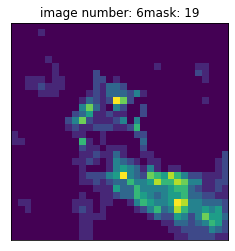

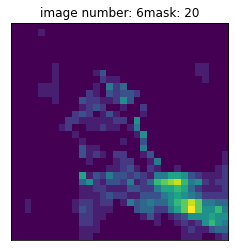

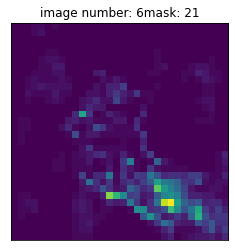

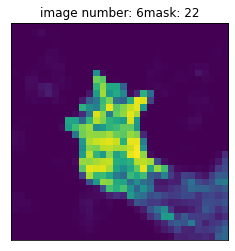

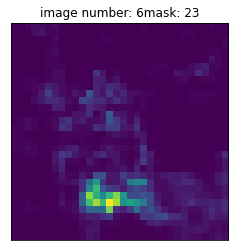

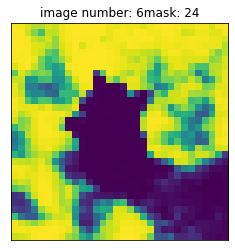

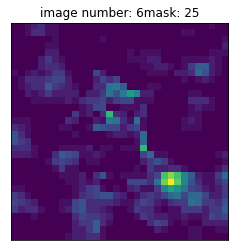

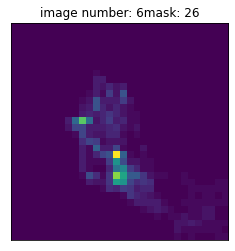

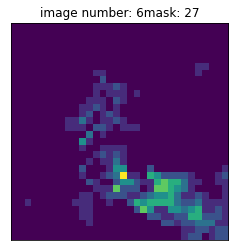

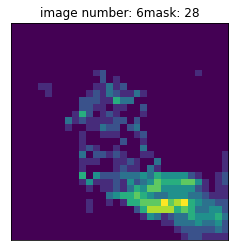

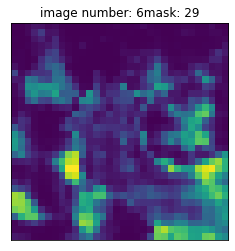

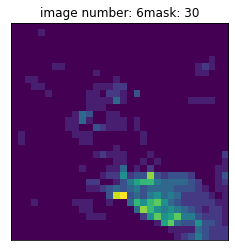

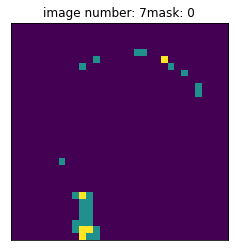

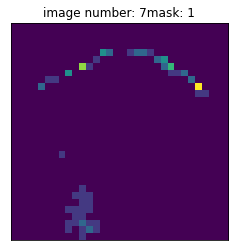

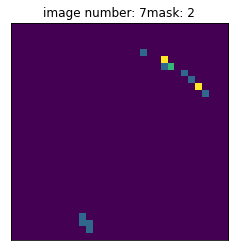

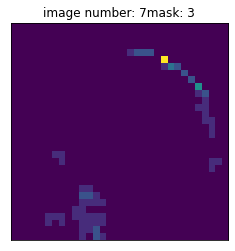

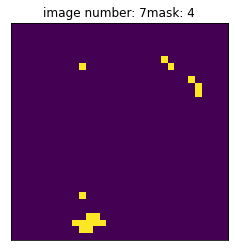

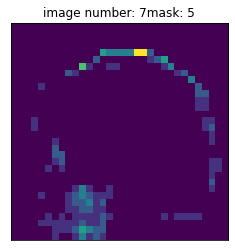

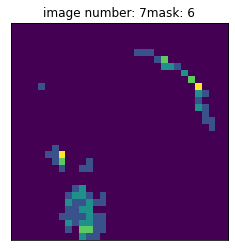

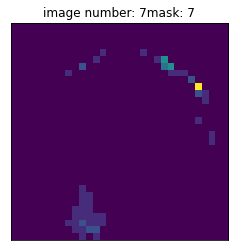

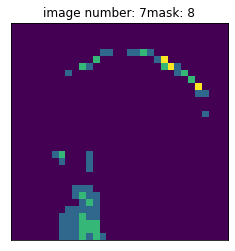

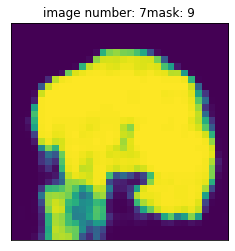

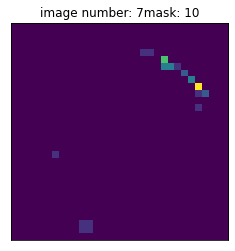

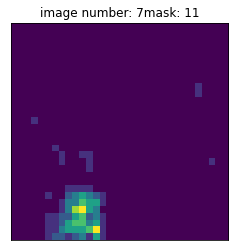

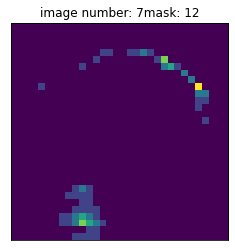

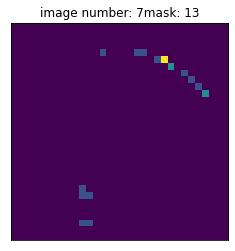

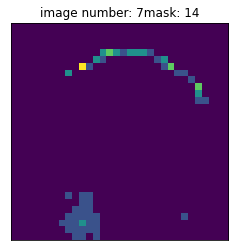

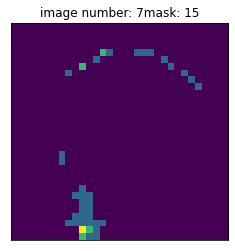

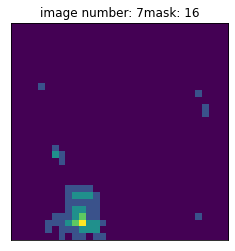

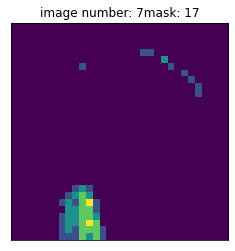

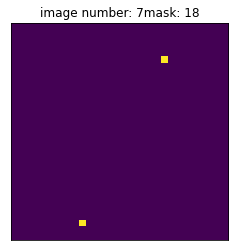

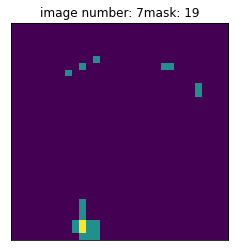

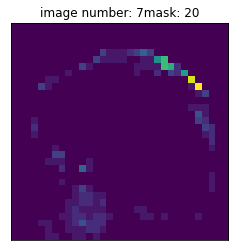

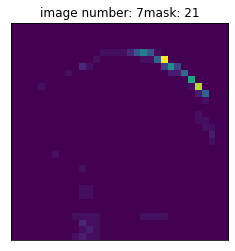

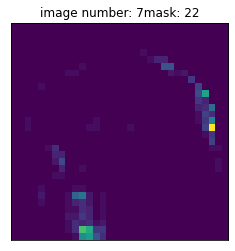

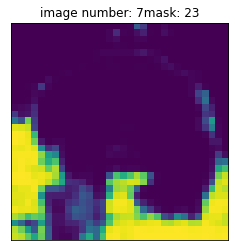

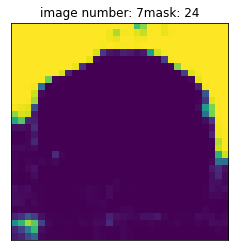

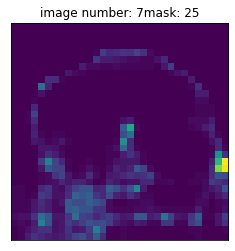

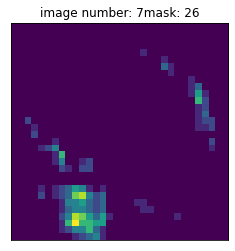

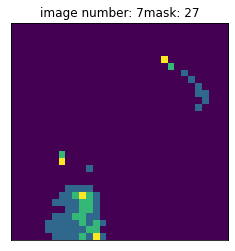

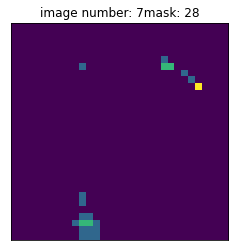

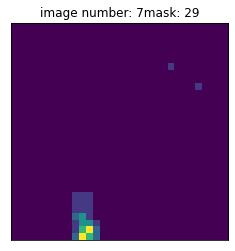

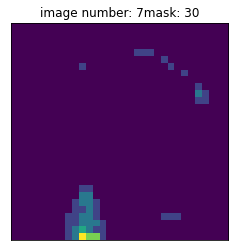

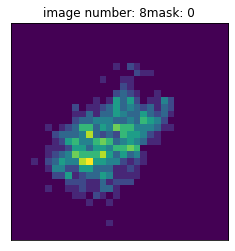

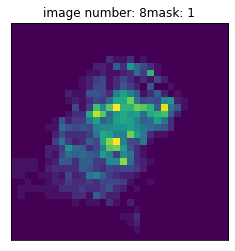

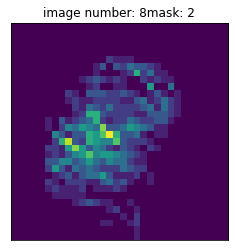

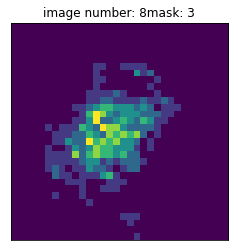

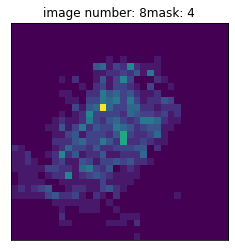

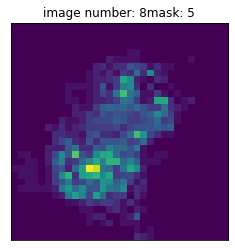

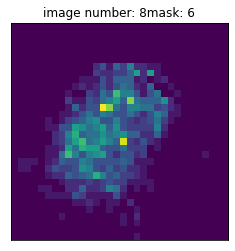

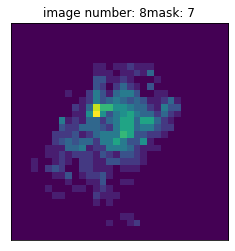

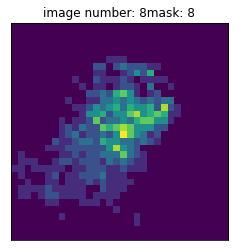

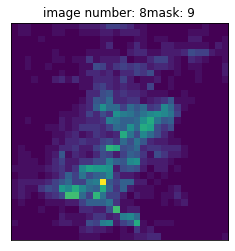

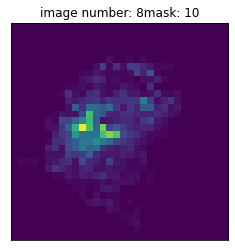

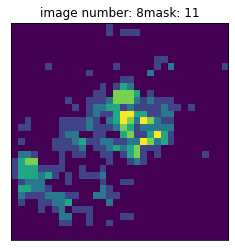

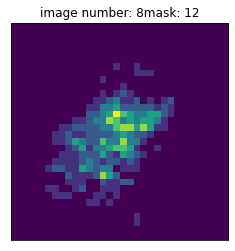

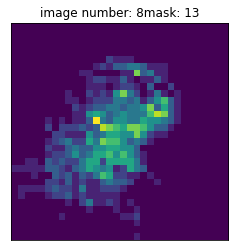

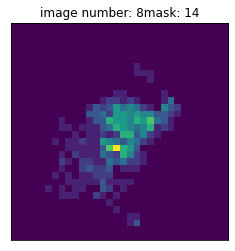

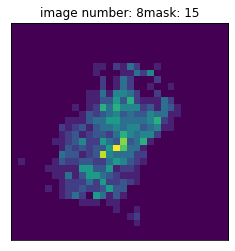

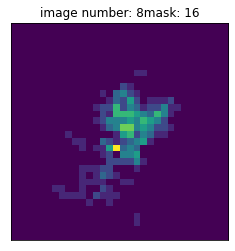

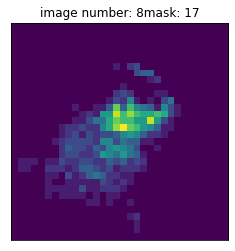

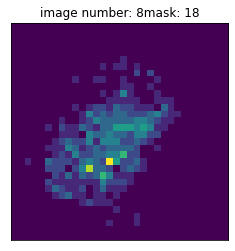

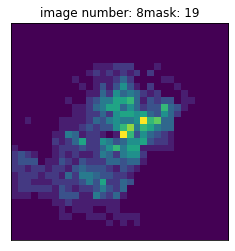

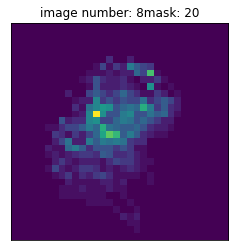

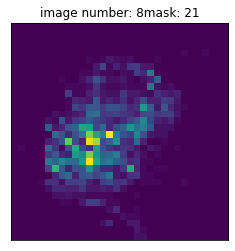

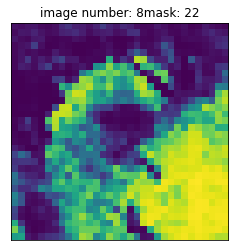

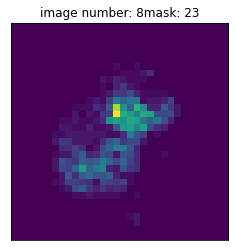

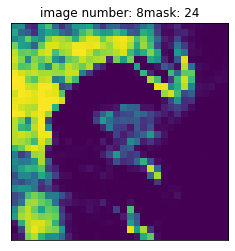

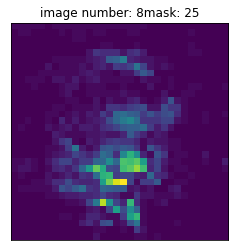

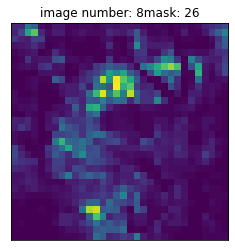

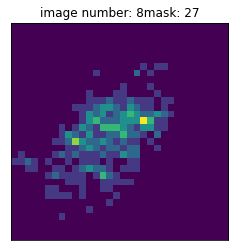

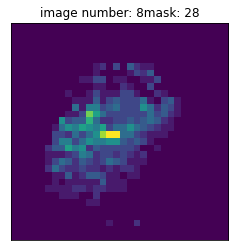

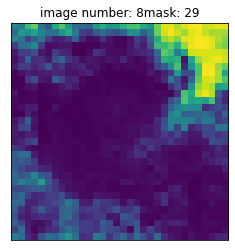

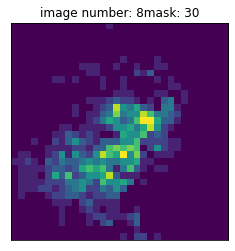

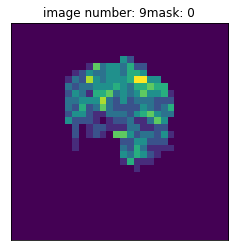

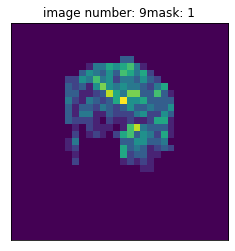

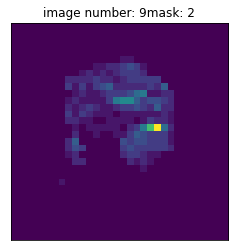

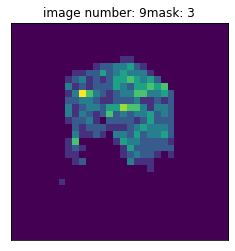

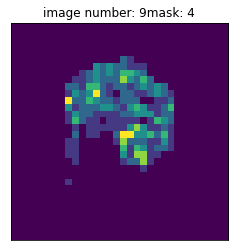

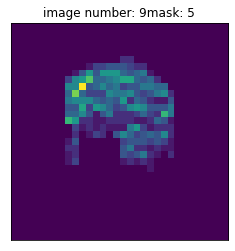

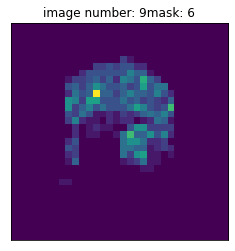

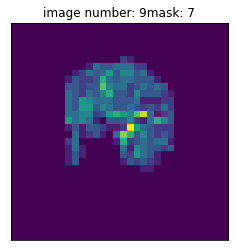

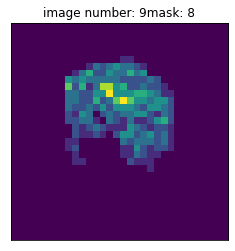

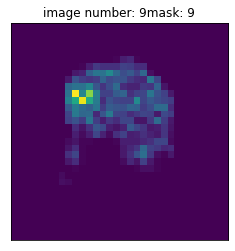

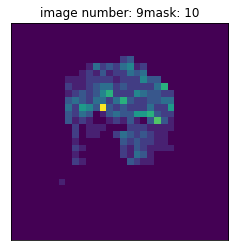

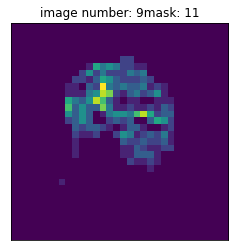

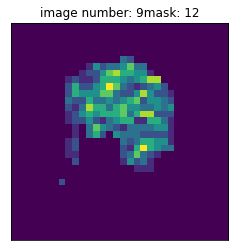

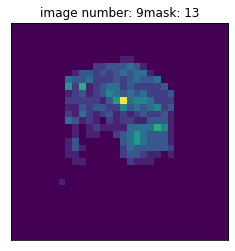

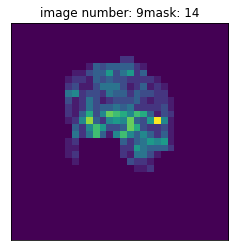

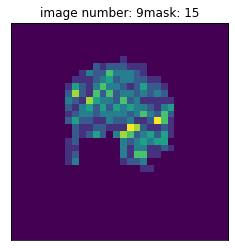

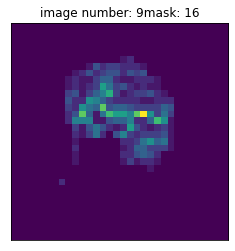

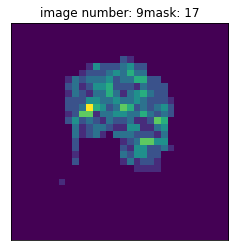

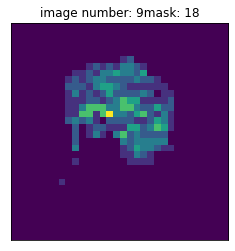

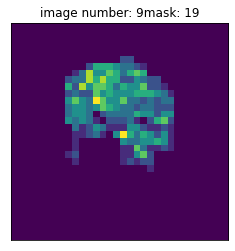

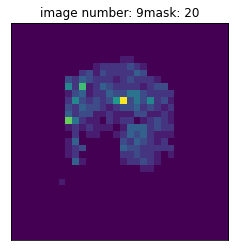

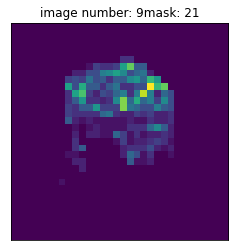

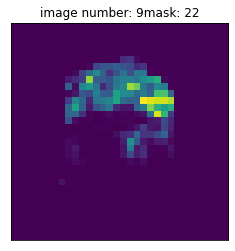

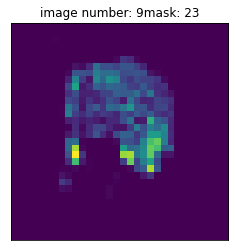

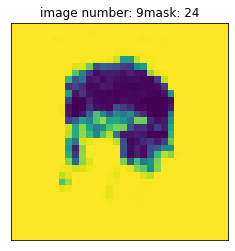

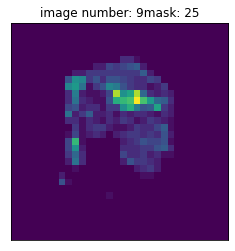

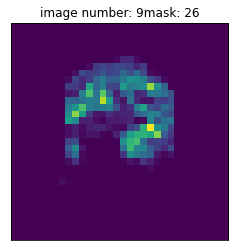

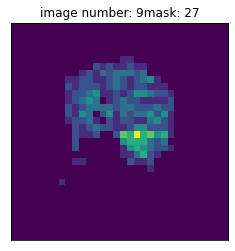

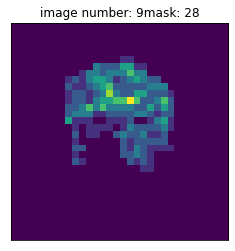

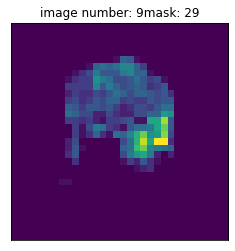

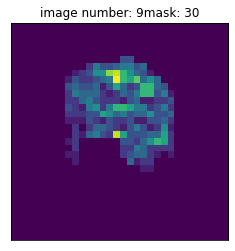

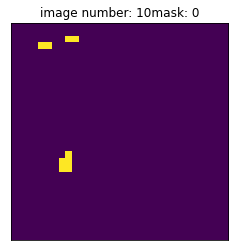

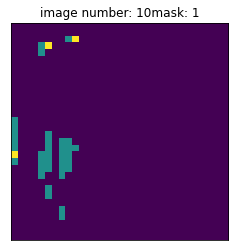

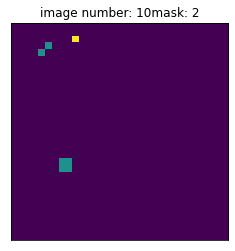

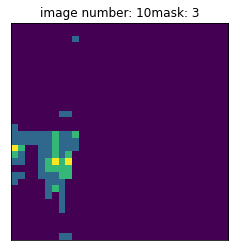

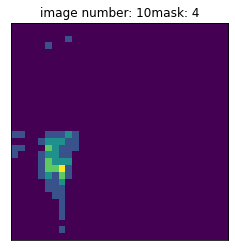

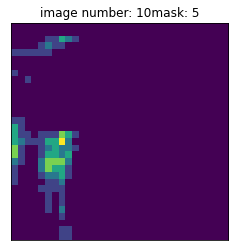

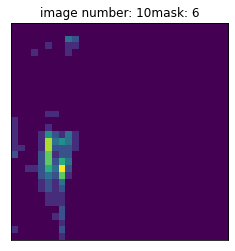

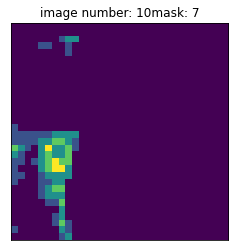

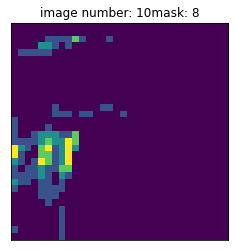

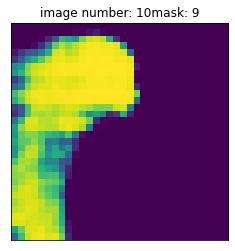

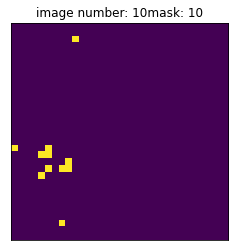

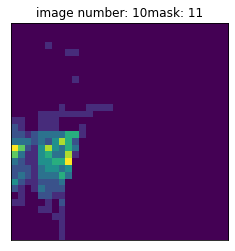

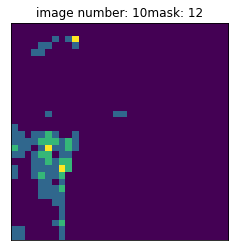

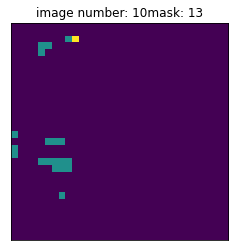

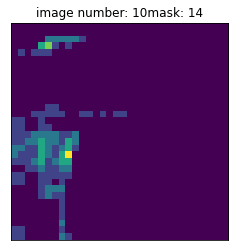

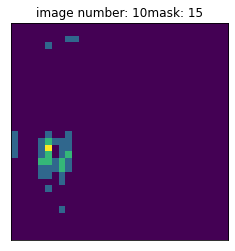

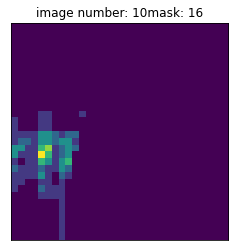

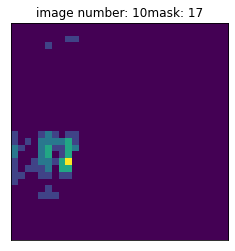

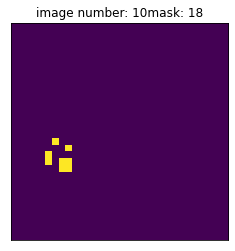

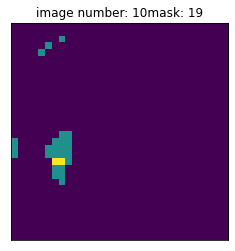

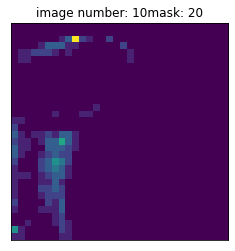

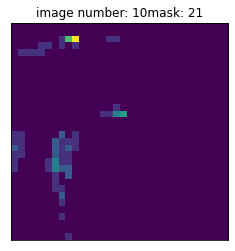

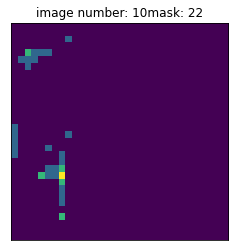

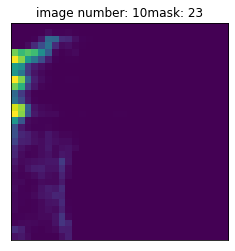

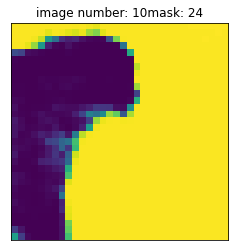

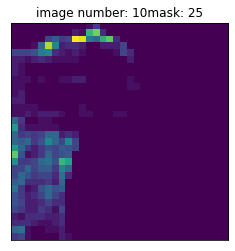

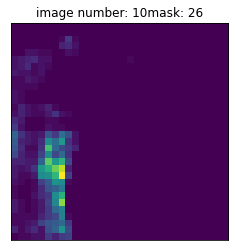

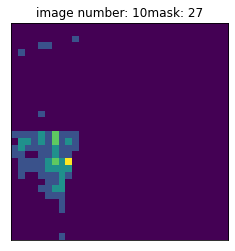

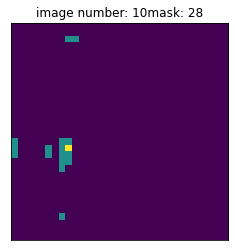

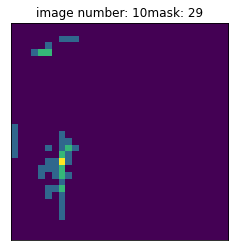

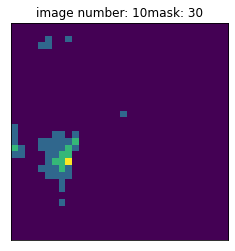

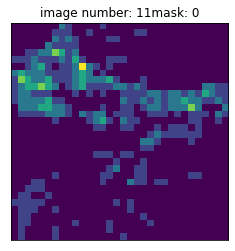

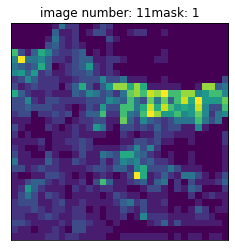

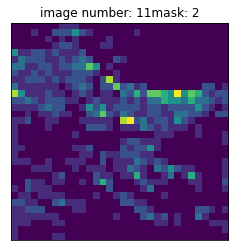

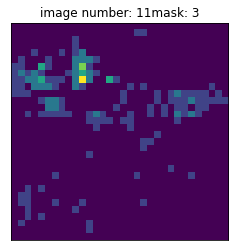

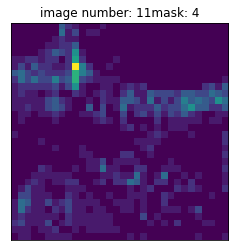

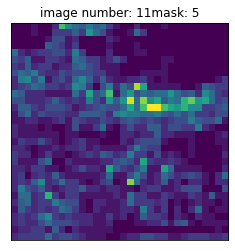

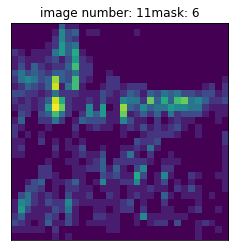

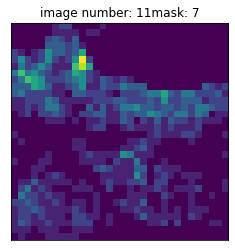

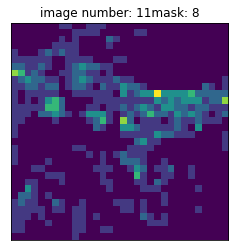

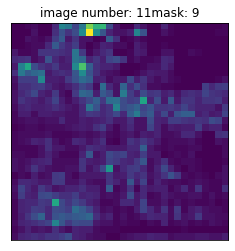

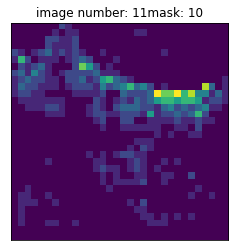

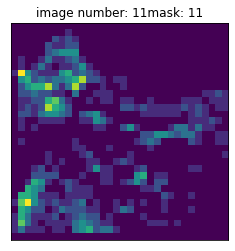

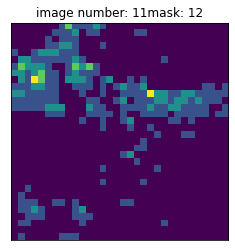

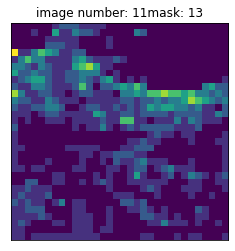

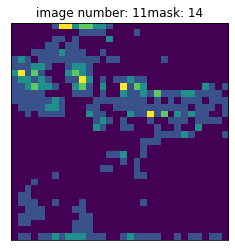

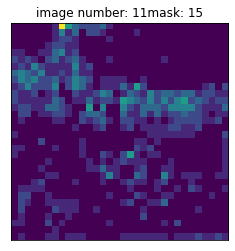

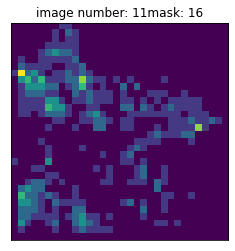

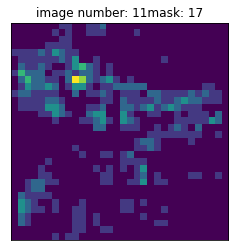

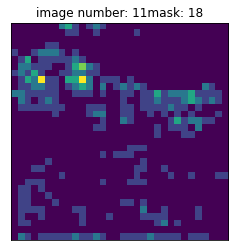

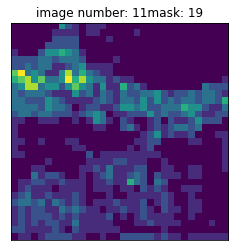

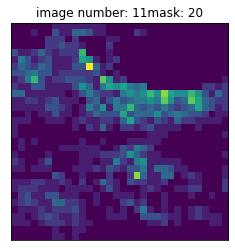

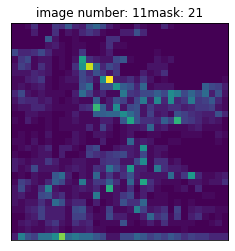

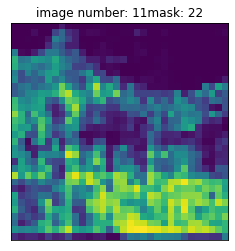

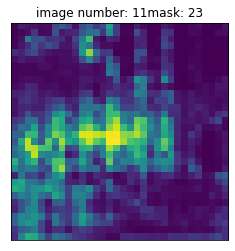

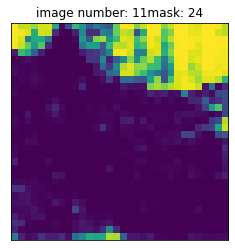

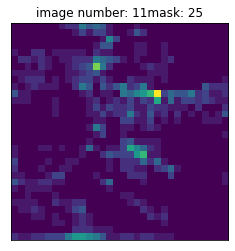

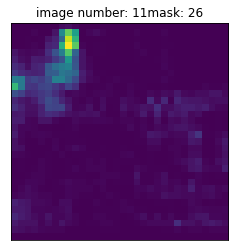

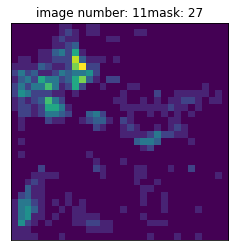

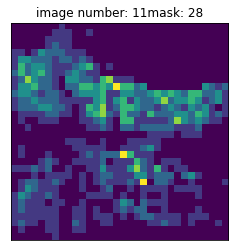

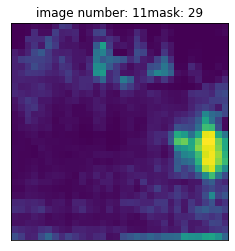

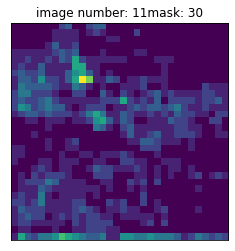

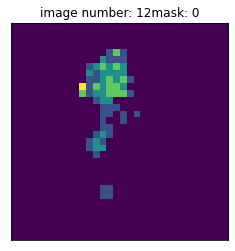

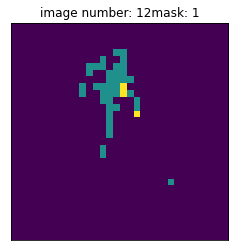

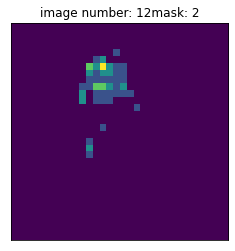

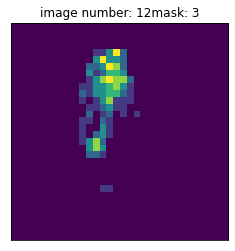

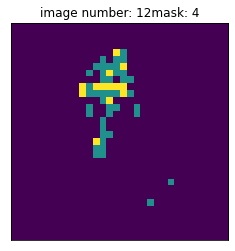

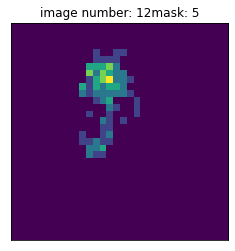

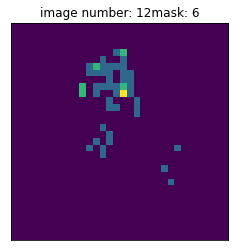

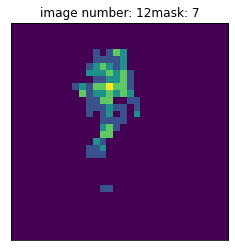

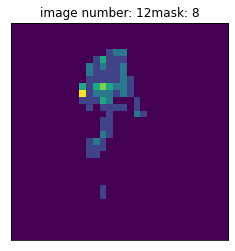

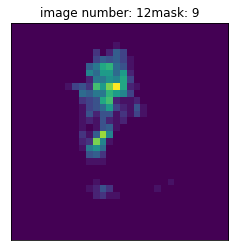

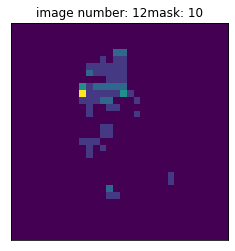

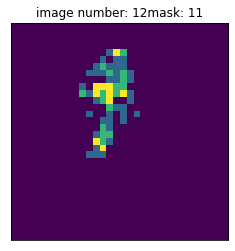

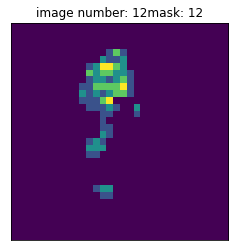

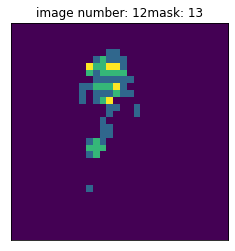

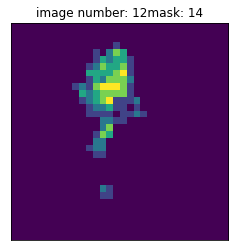

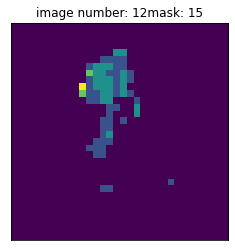

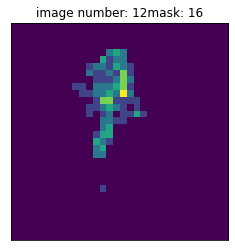

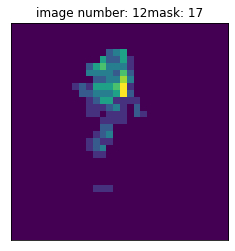

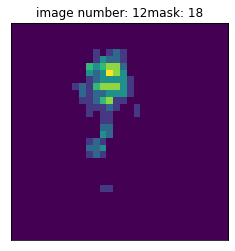

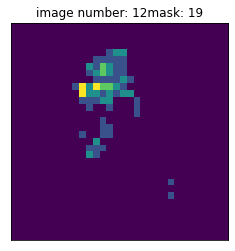

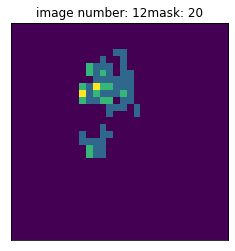

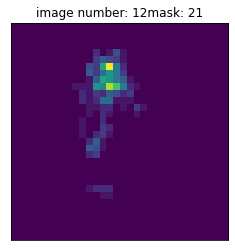

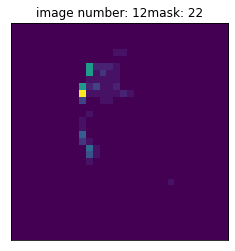

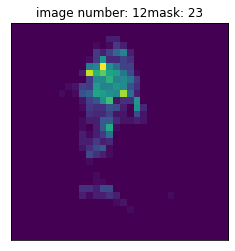

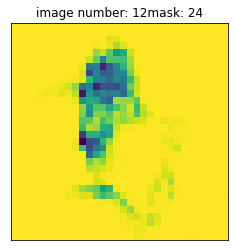

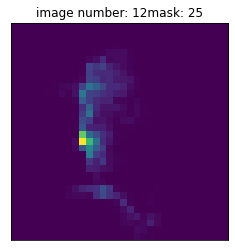

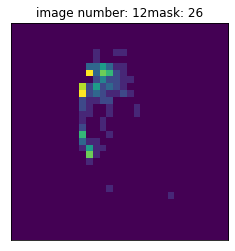

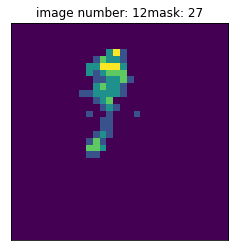

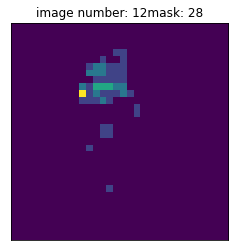

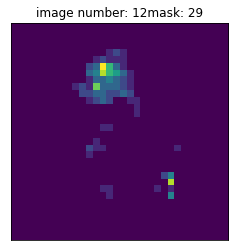

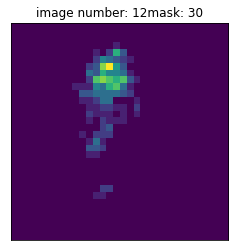

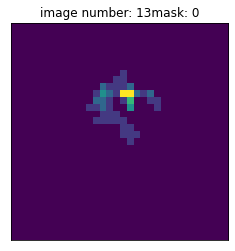

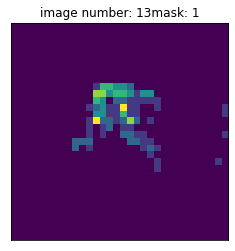

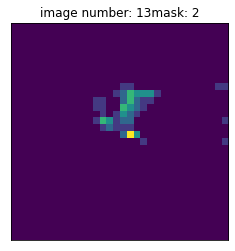

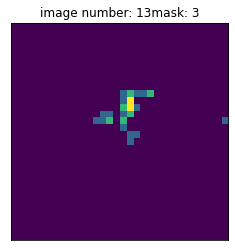

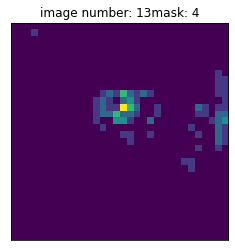

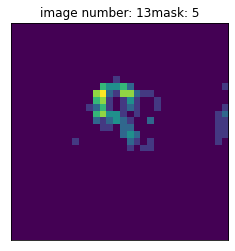

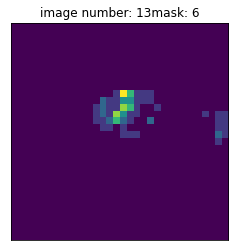

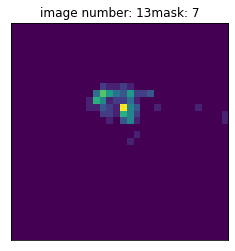

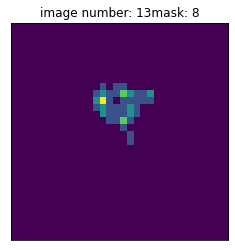

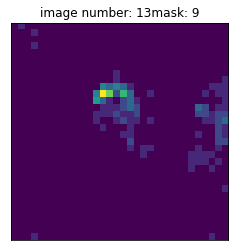

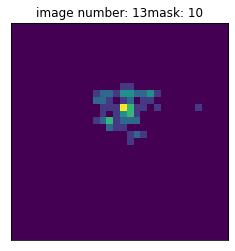

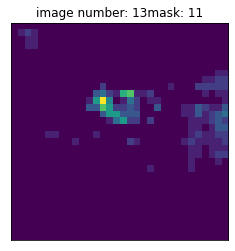

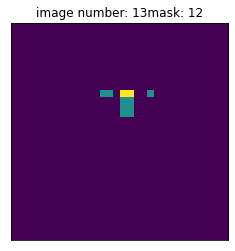

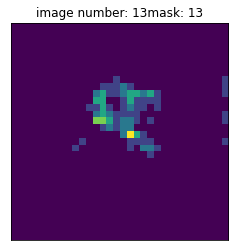

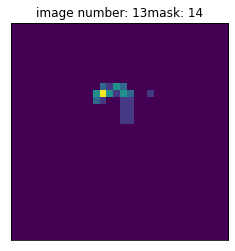

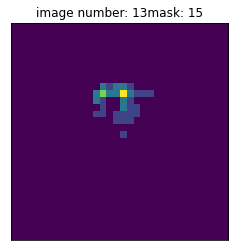

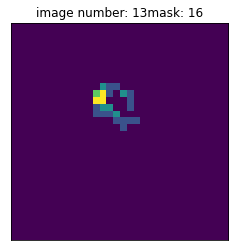

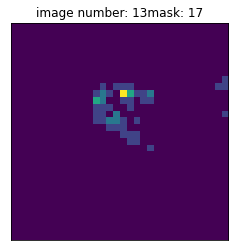

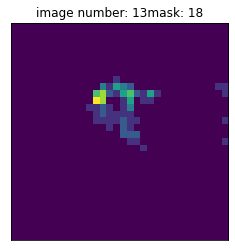

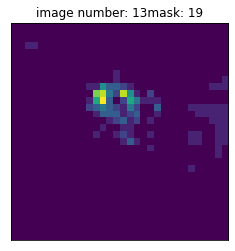

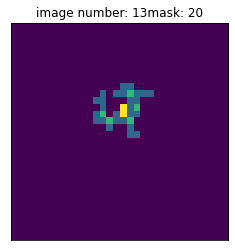

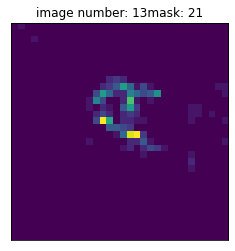

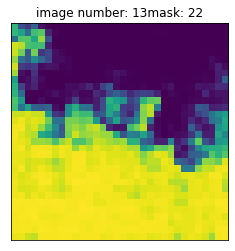

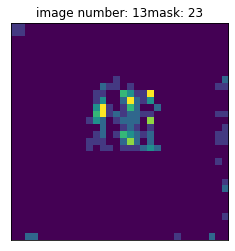

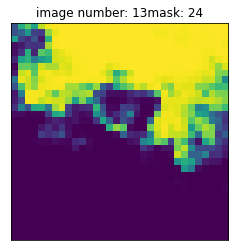

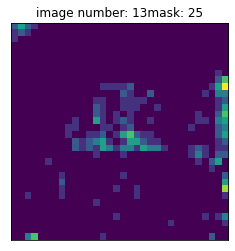

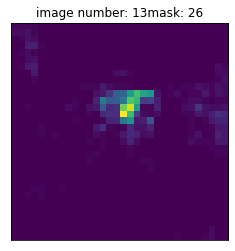

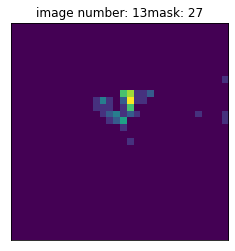

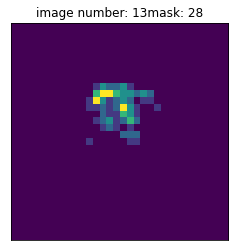

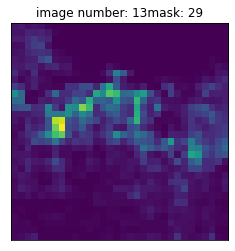

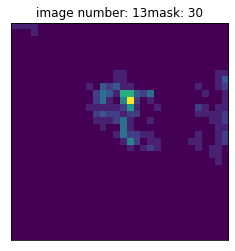

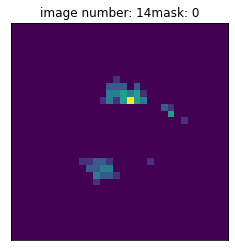

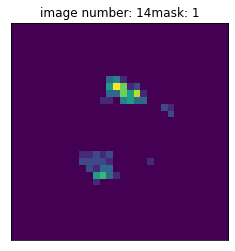

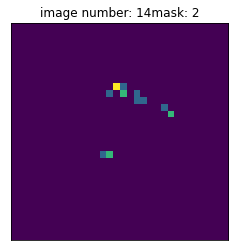

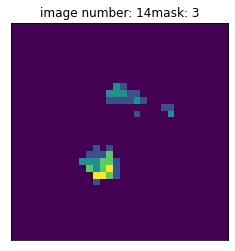

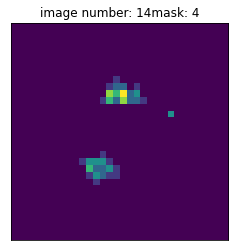

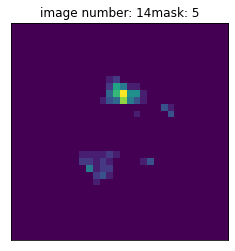

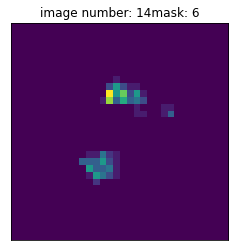

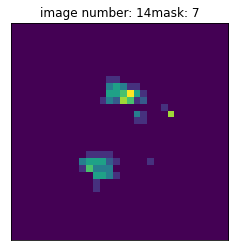

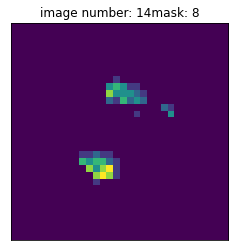

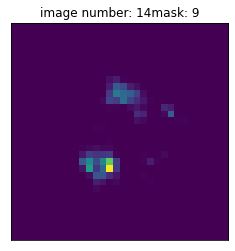

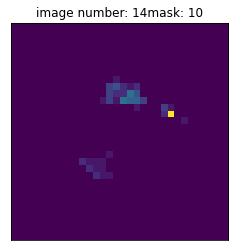

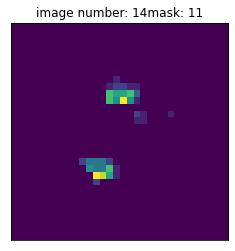

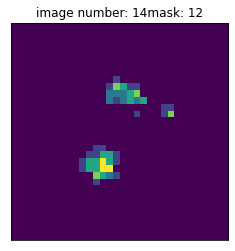

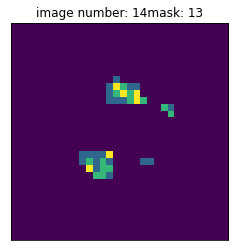

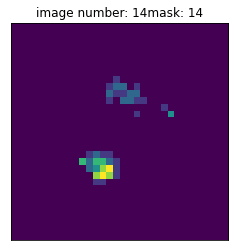

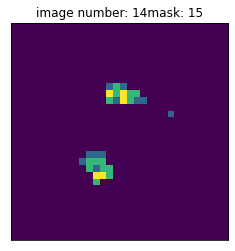

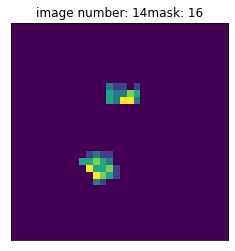

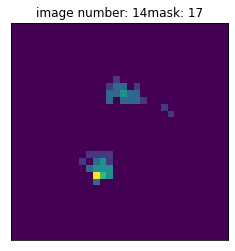

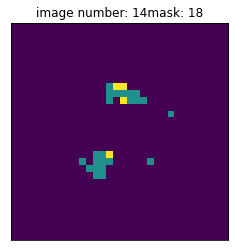

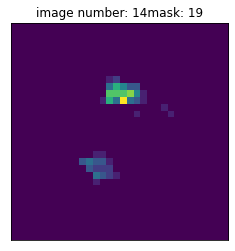

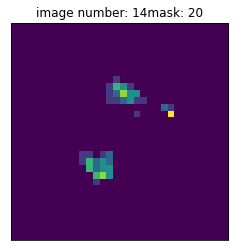

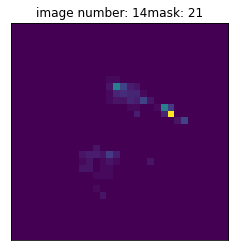

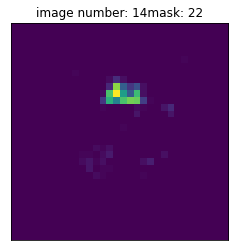

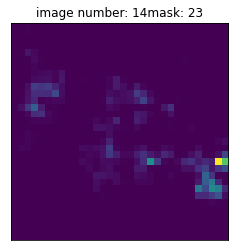

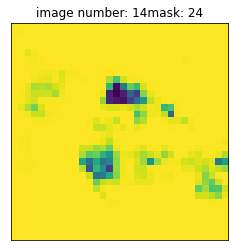

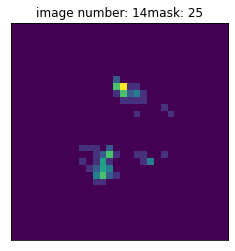

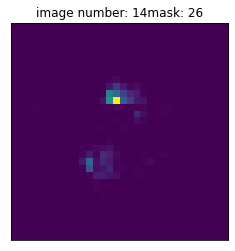

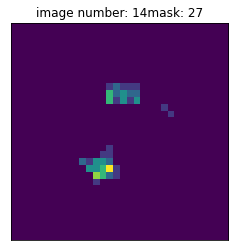

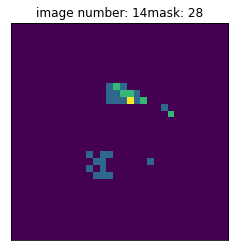

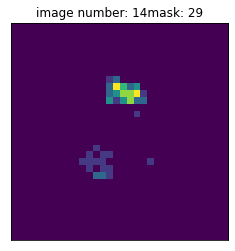

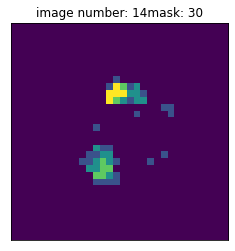

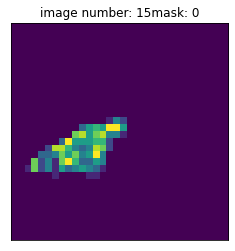

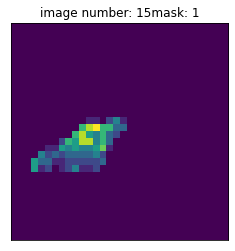

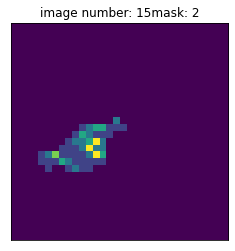

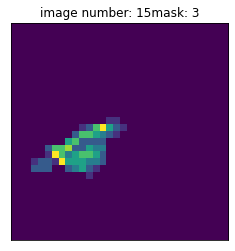

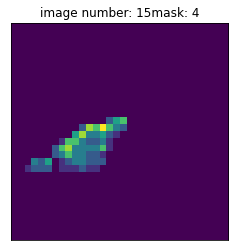

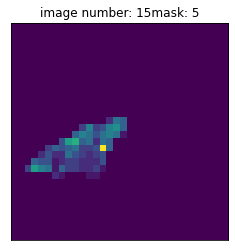

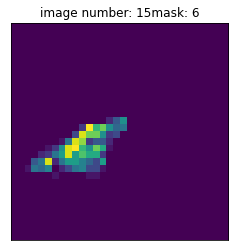

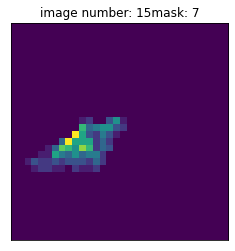

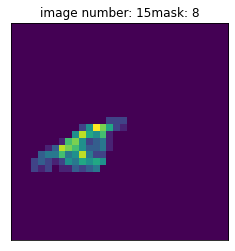

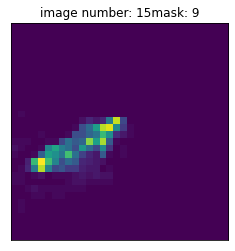

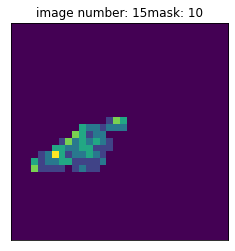

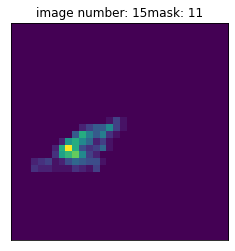

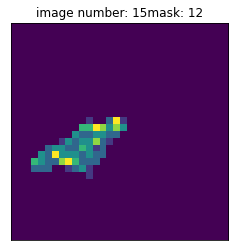

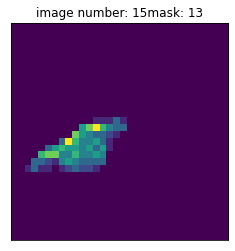

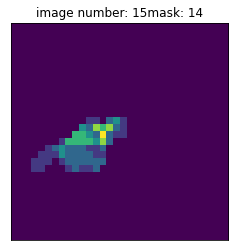

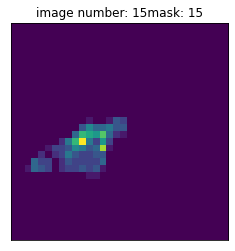

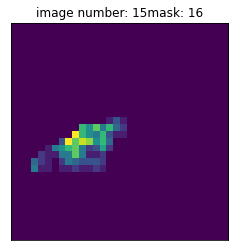

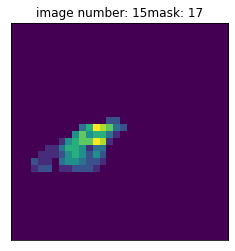

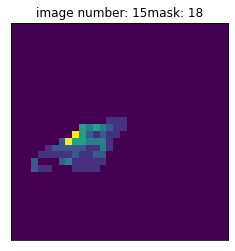

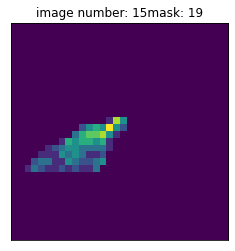

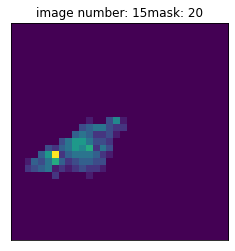

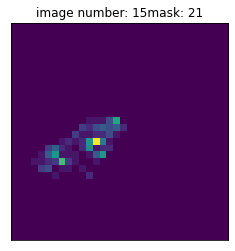

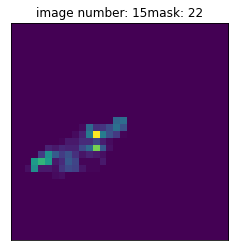

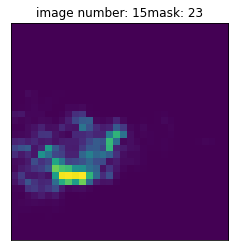

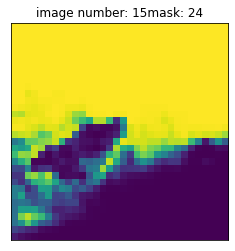

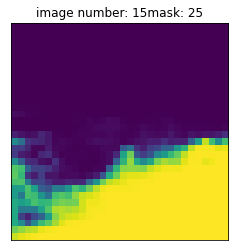

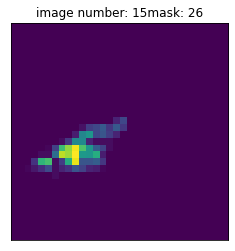

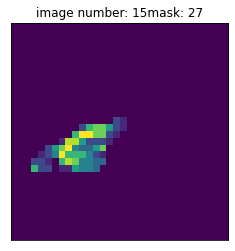

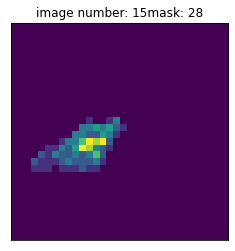

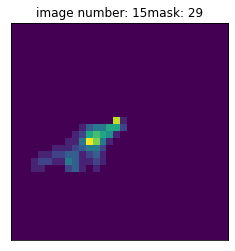

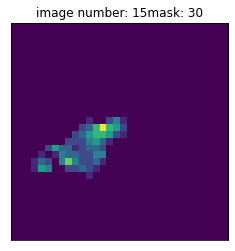

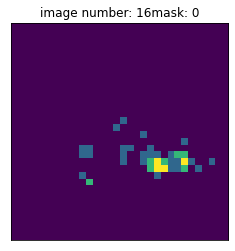

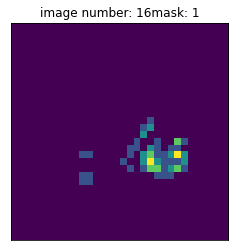

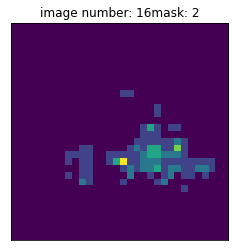

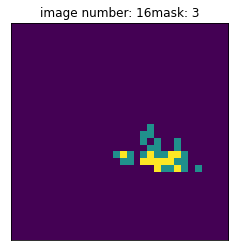

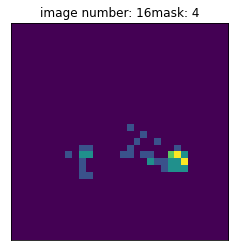

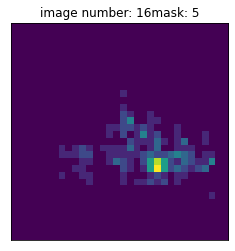

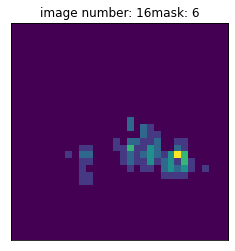

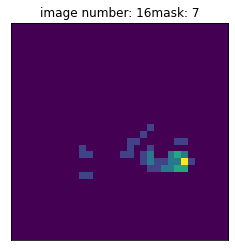

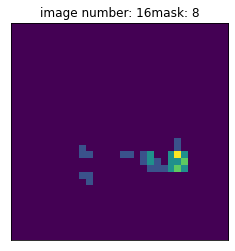

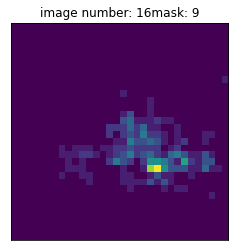

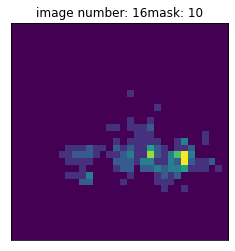

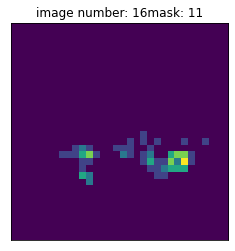

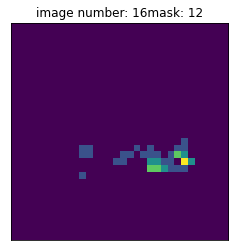

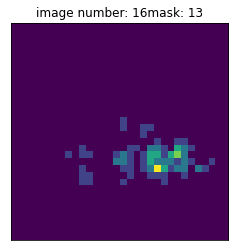

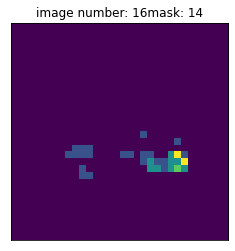

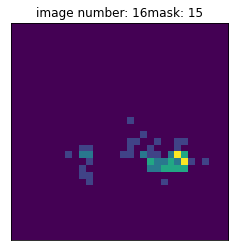

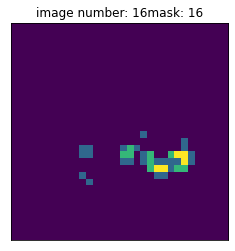

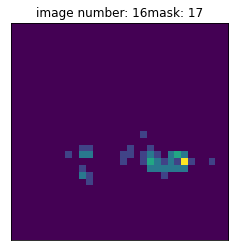

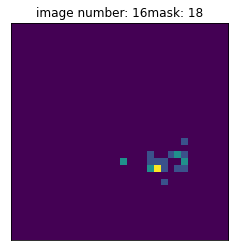

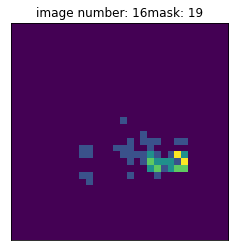

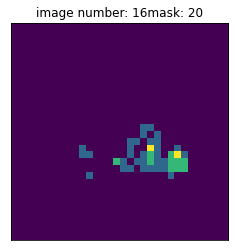

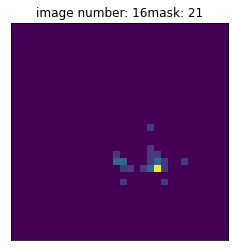

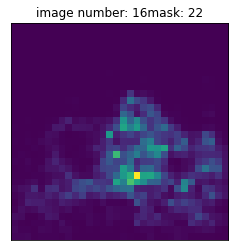

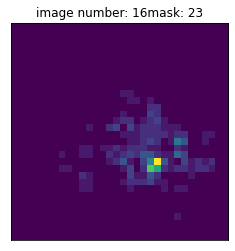

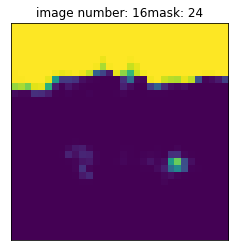

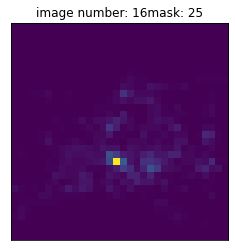

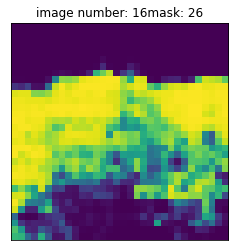

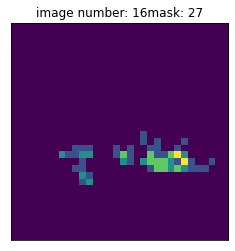

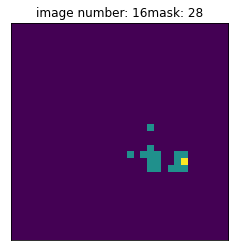

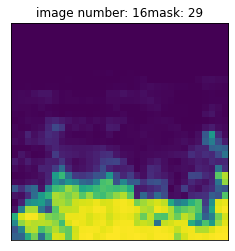

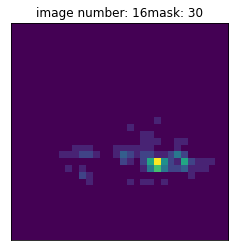

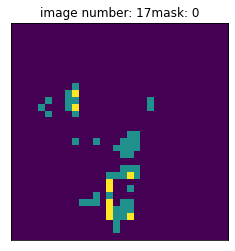

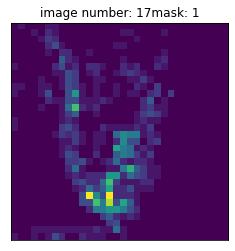

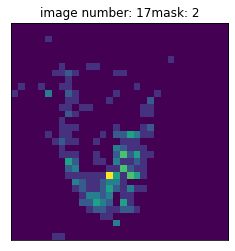

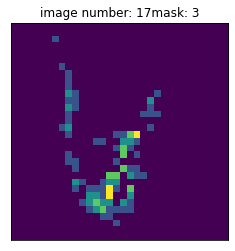

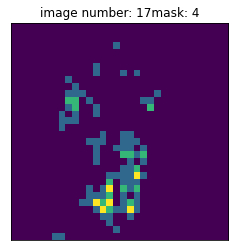

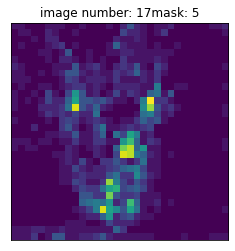

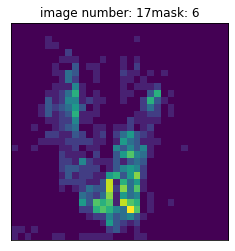

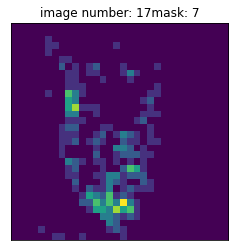

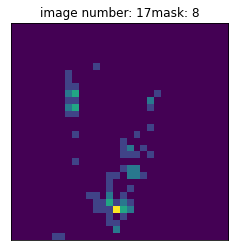

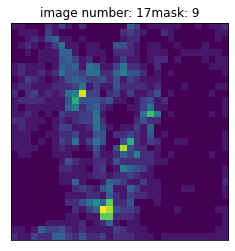

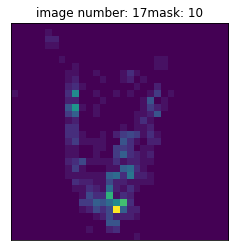

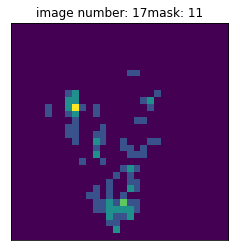

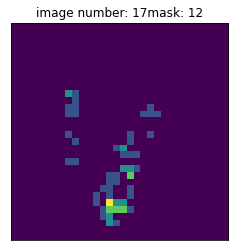

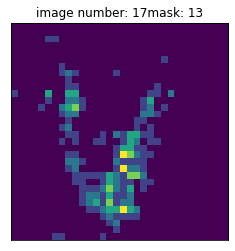

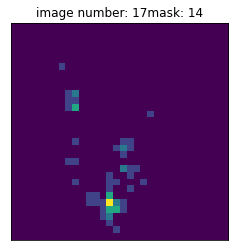

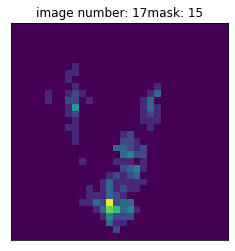

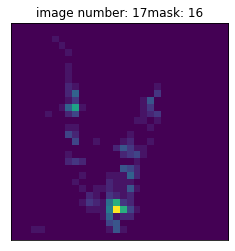

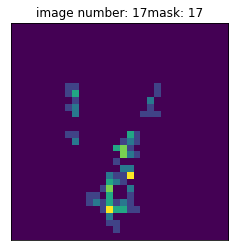

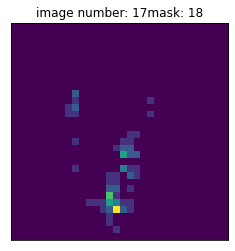

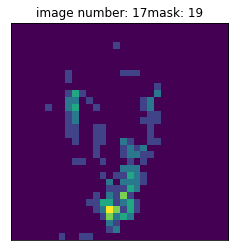

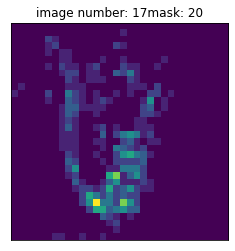

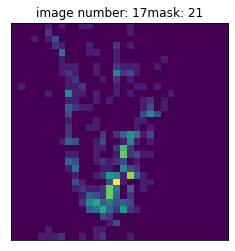

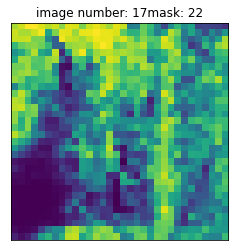

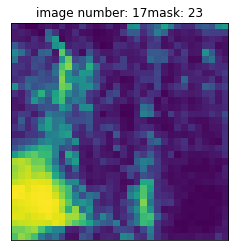

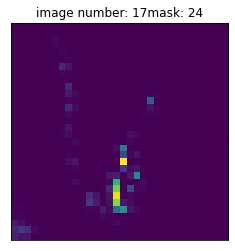

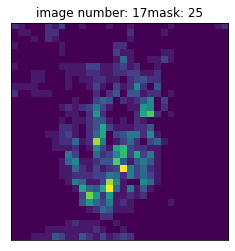

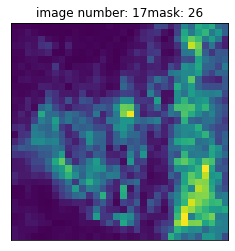

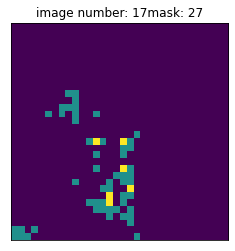

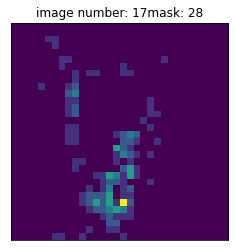

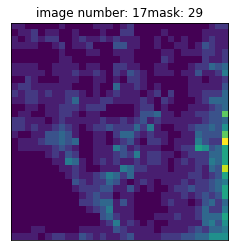

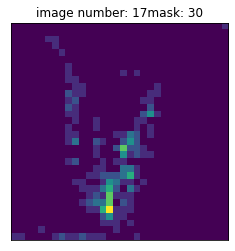

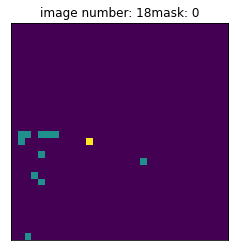

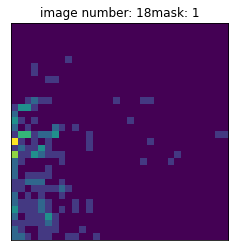

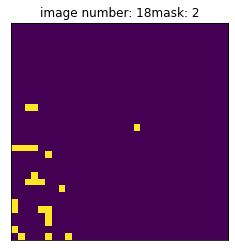

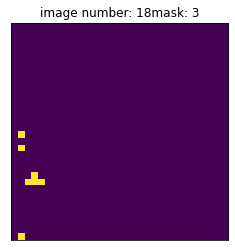

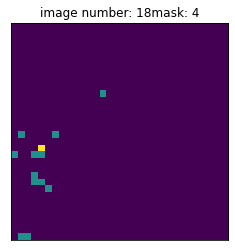

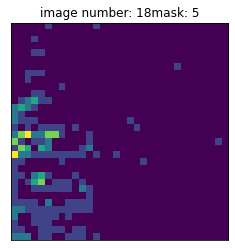

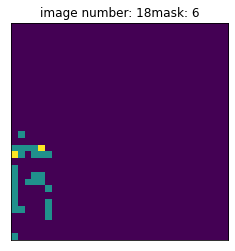

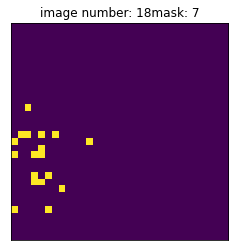

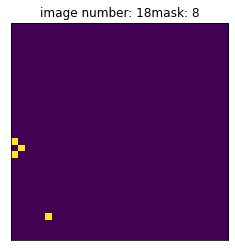

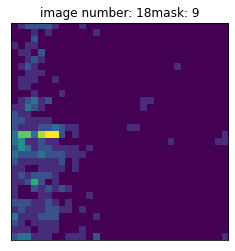

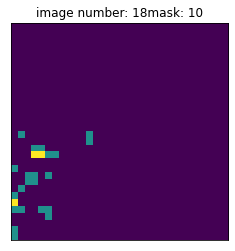

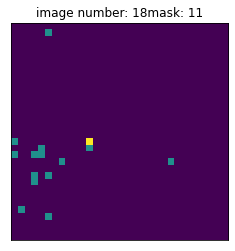

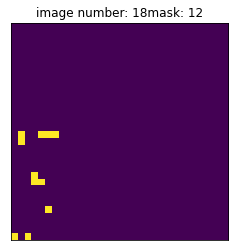

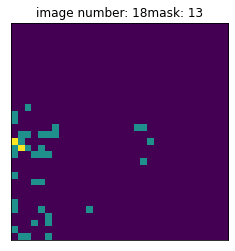

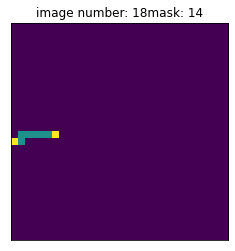

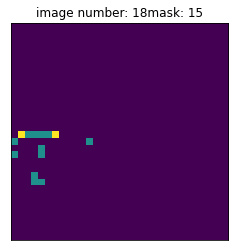

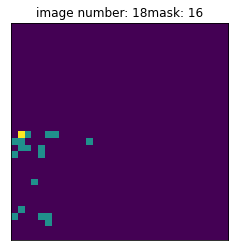

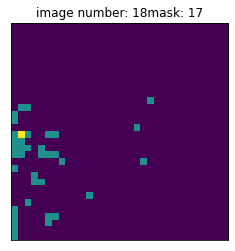

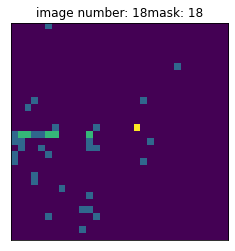

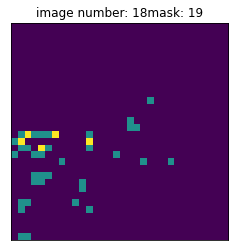

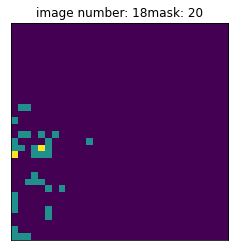

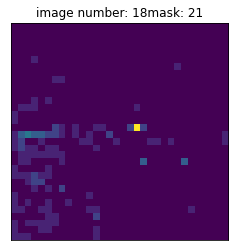

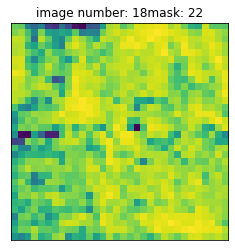

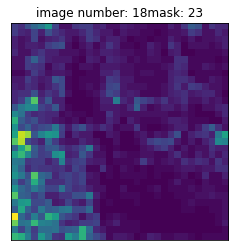

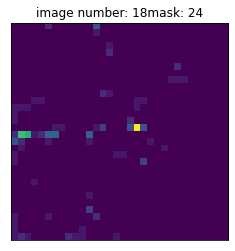

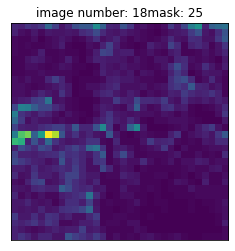

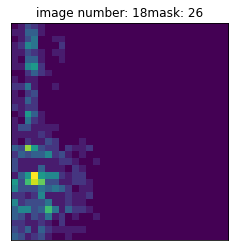

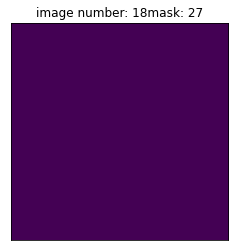

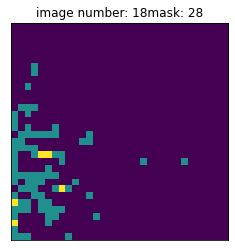

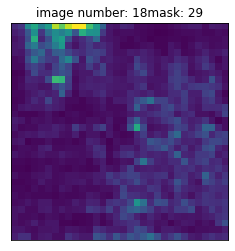

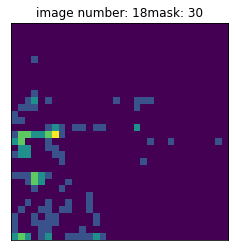

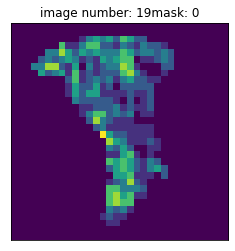

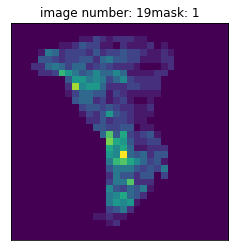

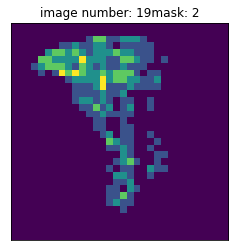

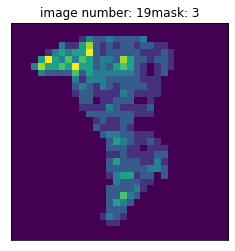

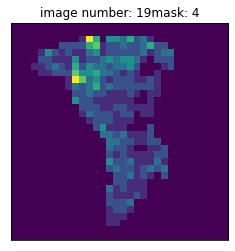

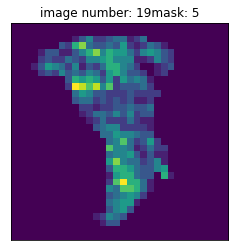

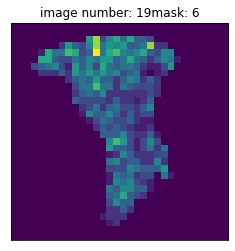

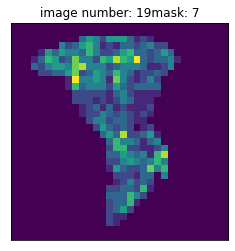

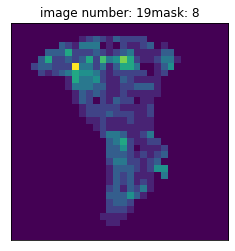

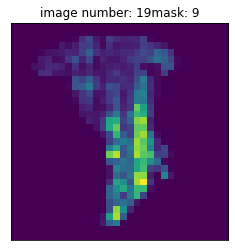

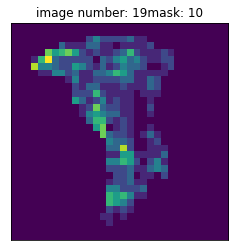

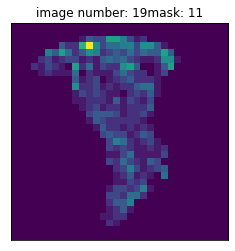

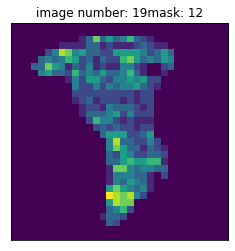

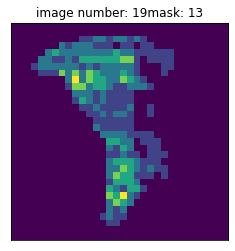

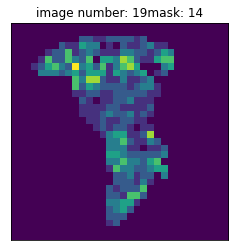

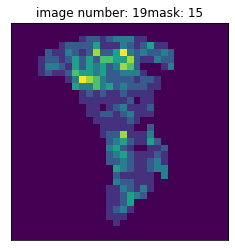

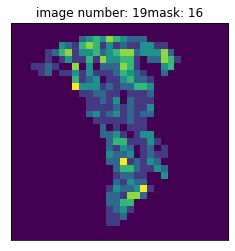

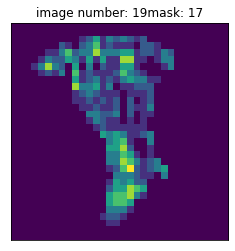

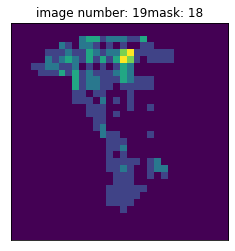

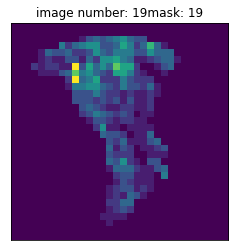

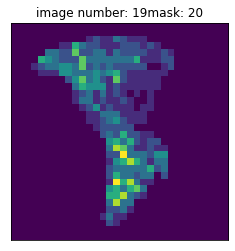

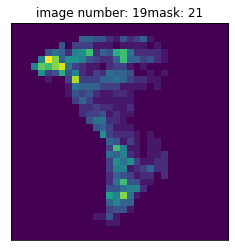

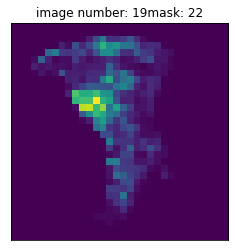

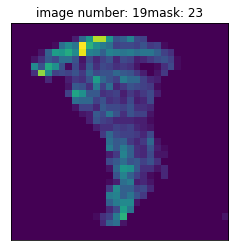

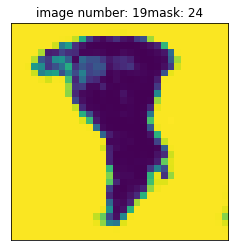

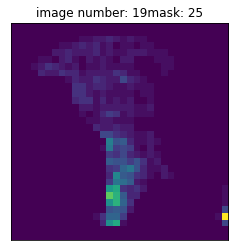

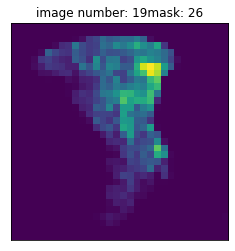

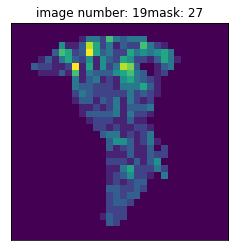

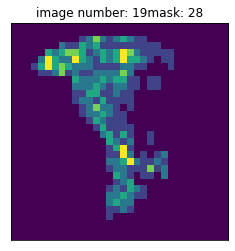

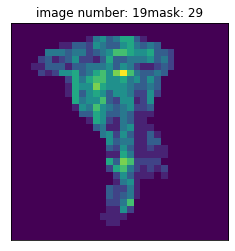

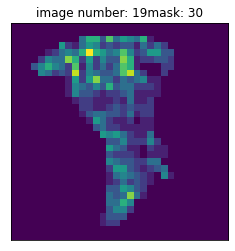

In [25]:

import matplotlib.pyplot as plt
def show(imgs,Image_number,number):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].set_title("image number: "+str(Image_number)+"mask: "+str(number))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
Image_num = 0
num = 0        
for mask in masks:
    if num>30:
        num = 0
        Image_num +=1
#     print(i)
    show(mask,Image_num,num)
    num+=1
    
# show(masks)